In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import time
import ignite
import numpy as np
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from typing import List, Callable
import pickle
import tqdm
import pytorch_lightning as pl
import torchmetrics
import os.path
import cv2
import csv
import pandas as pd
#from google.colab import drive
from google.colab.patches import cv2_imshow
import fnmatch
from math import sqrt
from PIL import Image
import joblib
from torch_lr_finder import LRFinder
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import TensorBoardLogger
import tensorflow as tf
from matplotlib import pyplot as plt

/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.8.1+cu101


## Parameters

In [4]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
WD = 1e-4
DATASET = 'RLBench_1000_TFM'

## Data Classes

In [5]:
# Modificamos la carpeta 
print(os.getcwd())
try:
    print(os.listdir("Pruebas ImitAI"))
    os.chdir("Pruebas ImitAI/" + DATASET)
except:
    print(os.listdir("../../Pruebas ImitAI"))
    os.chdir("../../Pruebas ImitAI/" + DATASET)
#os.chdir("../Prueba")
os.listdir()

/home/hodei.zia/ImitAI Project
['2000 pruebas', '2000_Pruebas', 'Dataset_Mujoco_New', 'Dataset_Mujoco_Button', 'Dataset_Mujoco_Window', 'Dataset_Mujoco_Window_v2', 'Dataset Pelota 375 TFM', 'RLBench_1000_TFM']


['Test_dataset',
 'Train_dataset',
 'MinMax_scaler.save',
 'RLBench_0.141-5_P_ALL',
 'RLBench_0.043-5_V_Front',
 'RLBench_0.717-5_V_Overhead',
 'RLBench_0.077-5_V_Left',
 'RLBench_0.09-5_V_Right',
 'RLBench_0.397-5_V_Wrist']

### Normalizamos las acciones y obtenemos el array de tamaños

In [6]:
print(os.getcwd())
print(os.listdir())

# Velocities
with open('Train_dataset/Train_Actions_V.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x_transformed = scaler.fit_transform(x)
np.savetxt('Train_dataset/Train_Actions_Normalized_V.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

with open('Test_dataset/Test_Actions_V.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x_transformed = scaler.fit_transform(x)
np.savetxt('Test_dataset/Test_Actions_Normalized_V.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

# Positions
with open('Train_dataset/Train_Actions_P.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x_transformed = scaler.fit_transform(x)
np.savetxt('Train_dataset/Train_Actions_Normalized_P.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

with open('Test_dataset/Test_Actions_P.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x_transformed = scaler.fit_transform(x)
np.savetxt('Test_dataset/Test_Actions_Normalized_P.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

# Train

observaciones = fnmatch.filter(os.listdir('../../Pruebas ImitAI/' + DATASET + '/Train_dataset'), '0_V*')

ordenado=[]
for i in observaciones:
    ordenado.append(int(i.split(".")[0].split("_")[2]))
ordenado=sorted(ordenado)

tamPruebasTrain=[0]
j=0
for observacion in ordenado:
    observacion="0_V_"+str(observacion)+".csv"
    tam=len(pd.read_csv("../../Pruebas ImitAI/" + DATASET + "/Train_dataset/" + str(observacion)))
    j+=tam
    tamPruebasTrain.append(j)
    
#print(tamPruebas)

# Test

observaciones = fnmatch.filter(os.listdir('../../Pruebas ImitAI/' + DATASET + '/Test_dataset'), '0_V*')

ordenado=[]
for i in observaciones:
    ordenado.append(int(i.split(".")[0].split("_")[2]))
ordenado=sorted(ordenado)

tamPruebasTest=[0]
j=0
for observacion in ordenado:
    observacion="0_V_"+str(observacion)+".csv"
    tam=len(pd.read_csv("../../Pruebas ImitAI/" + DATASET + "/Test_dataset/" + str(observacion)))
    j+=tam
    tamPruebasTest.append(j)

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/RLBench_1000_TFM
['Test_dataset', 'Train_dataset', 'MinMax_scaler.save', 'RLBench_0.141-5_P_ALL', 'RLBench_0.043-5_V_Front', 'RLBench_0.717-5_V_Overhead', 'RLBench_0.077-5_V_Left', 'RLBench_0.09-5_V_Right', 'RLBench_0.397-5_V_Wrist']


In [7]:
scaler_filename = "MinMax_scaler.save"
scaler_to_save = MinMaxScaler(feature_range=(-1, 1))
joblib.dump(scaler_to_save, scaler_filename) 
scaler_loaded = joblib.load(scaler_filename)

In [8]:
'''
listaImagenes=['Front_rgb', 'Overhead_rgb', 'Left_rgb', 'Right_rgb', 'Wrist_rgb']
all_train_images=[]
for image in listaImagenes:
    for idx in os.listdir("Train_dataset/"+listaImagenes[0]):
        all_train_images.append("Train_dataset/"+image+"/"+idx)

value_sum = np.zeros((3, ))
value_sum_sq = np.zeros((3, ))
count = 0
for i in all_train_images:
    img = np.array(Image.open(i)) / 255.0
    # Obtener la suma por canales
    value_sum += img.sum(axis=(0,1))
    value_sum_sq += np.square(img).sum(axis=(0, 1))
    # Contar cuantos elementos se han sumado en cada canal (128x128)
    count += np.prod(img.shape[:2])
# Calcular media y desviacion
mean = value_sum / count
print(mean)
var  = (value_sum_sq / count) - (mean ** 2)
std  = np.sqrt(var)
print(std)
'''

'\nlistaImagenes=[\'Front_rgb\', \'Overhead_rgb\', \'Left_rgb\', \'Right_rgb\', \'Wrist_rgb\']\nall_train_images=[]\nfor image in listaImagenes:\n    for idx in os.listdir("Train_dataset/"+listaImagenes[0]):\n        all_train_images.append("Train_dataset/"+image+"/"+idx)\n\nvalue_sum = np.zeros((3, ))\nvalue_sum_sq = np.zeros((3, ))\ncount = 0\nfor i in all_train_images:\n    img = np.array(Image.open(i)) / 255.0\n    # Obtener la suma por canales\n    value_sum += img.sum(axis=(0,1))\n    value_sum_sq += np.square(img).sum(axis=(0, 1))\n    # Contar cuantos elementos se han sumado en cada canal (128x128)\n    count += np.prod(img.shape[:2])\n# Calcular media y desviacion\nmean = value_sum / count\nprint(mean)\nvar  = (value_sum_sq / count) - (mean ** 2)\nstd  = np.sqrt(var)\nprint(std)\n'

In [8]:
# mean 375 = [0.69005291   , 0.58671548   , 0.37808829]
# std 375 = [0.2334039    , 0.18042767   ,  0.18387934]
# 2000 [0.68974503 0.58716836 0.3785121 ]
# 2000 [0.23427996 0.17952413 0.18298983]

# 1000 [0.6899635 0.58672529 0.37841368]
# 1000 [0.23346919 0.18057981 0.1842612]

In [9]:
mean = [0.6899635, 0.58672529, 0.37841368]
std = [0.23346919, 0.18057981, 0.1842612]


## Model

We use a pretrained ResNet18 for now. We have to remove the classifier head because it is traiend for classification with 1000 classes. We add a custom head to make regression of 7 values

In [10]:
class MultiImage(nn.Module):
    def __init__(self, fe, clf):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x1, x2, x3, x4, x5, x6 = x

        f1 = self.flatten(self.avg_pool(self.fe(x1)))
        f = torch.cat((f1, x2, x3, x4, x5, x6), dim=1)
        return self.clf(f)

In [11]:
# To pretrain
model = models.resnet18(pretrained=False)

# Change the first convolution
new_conv = torch.nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = list(model.children())[1:]
model = [new_conv] + model
model = torch.nn.Sequential(*model)

# Get only the feature extractor (remove avgpool and fc layers)
fe = nn.Sequential(*list(model.children())[:-2])

def freeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(False)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(False)
            
def unfreeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(True)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(True)
            
# Freeze all but BatchNorm layers of feature extractor
# Uriz: if we use the "normal" ResNet use the pretained version and freeze all but BN
#       only set all trainiable when we change the fitst convolution layer to accept images of 6 dimensions
#       if the ResNet is pretrained and freezed the training accuracy is maintained (or increased) and the train time is dreceased
fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

# Create custom head
head_clf = nn.Sequential(
    nn.BatchNorm1d(512*5+7),
    nn.Dropout(0.25),
    nn.Linear(512*5+7, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
)

# Rebuild the model
model = MultiImage(fe, head_clf)

## Train Model

In [12]:
# Create trainable class with Pytorch Lightinng
class LitModel(pl.LightningModule):
    def __init__(self, model, loss_function, total_iterations, lr):
        """
        Constructor of the trainable class
        Args:
            model: PyTorch model
            loss_function: The loss function to use
            total_iterations: The total number of iterations for training (num_batches * num_epochs). Used for
                                LR Schedule
            lr: the max_lr to use for the OneCycleLR policy
        """
        super().__init__()
        # Store params
        self.model = model
        self.loss_function = loss_function
        self.total_iterations = total_iterations
        self.lr = lr
        # For measure the MSE
        self.train_mse = torchmetrics.MeanSquaredError()
        self.valid_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        # Forward method
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.train_mse(prediction, y)
        # Log loss and MSE
        self.log("training_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_mse', self.train_mse, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # Return Loss for backward
        return loss

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_mse.compute(), logger=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.valid_mse(prediction, y)
        # Log loss and MSE
        self.log('valid_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_mse', self.valid_mse, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.valid_mse.compute(), logger=True)

    def configure_optimizers(self):
        # Get Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # Set OneCycleLR policy
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr,
                                                             total_steps=self.total_iterations),
            'interval': 'step', 'frequency': 1, 'name': 'lr_logger'
        }
        return [optimizer], [lr_scheduler]

In [13]:
class CallbackClass(Callback):
    def __init__(self, what="epochs", verbose=True):
        self.what = what
        self.verbose = verbose
        self.state = {"epochs": 0}
        
    @property
    def state_key(self):
        # note: we do not include `verbose` here on purpose
        return self._generate_state_key(what=self.what)

    def on_train_epoch_end(self, *args, **kwargs):
        e = 0
        if self.what == "epochs":
            self.state["epochs"] += 1
            
        if self.state["epochs"] >= 5:
            for param in pl_model.parameters():
                param.requires_grad = True # Unfreeze
        
        for name, param in pl_model.named_parameters():
            if param.requires_grad:
                e = e+1

    def load_state_dict(self, state_dict):
        self.state.update(state_dict)

    def state_dict(self):
        return self.state.copy()

# Start
## Front + Left P

35999
1124
8806
276


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.99E-03


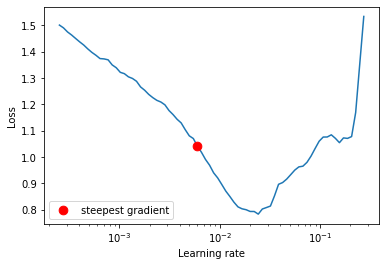

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
295 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.964    Total estimated model params size (MB)


0.00599484250318941
EPOCH NUMERO: 15


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


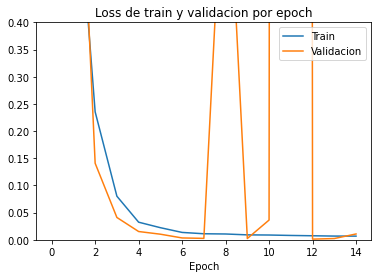

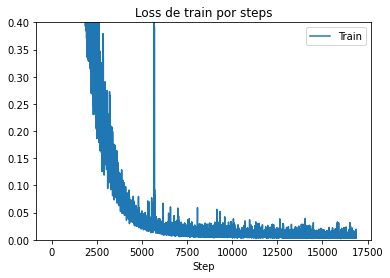

  0%|          | 0/276 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.0107278945
El valor RMSE es igual a 0.10357554968450507
[0.10357554968450507]
Num Epochs mejor prueba: 15
RMSE mejor prueba: 0.10357554968450507

Error total por articulacion: [0.24361825 0.04942601 0.06346987 0.05657857 0.02856764 0.05680649
 0.045062  ]
Articulacion 0 [-0.34 - 0.39] 0.73 33.37%
Articulacion 1 [-0.69 - 1.1] 1.79 2.76%
Articulacion 2 [-0.38 - 0.47] 0.85 7.47%
Articulacion 3 [-3.05 - -0.74] 2.31 2.45%
Articulacion 4 [-0.28 - 0.22] 0.5 5.71%
Articulacion 5 [1.22 - 3.03] 1.81 3.14%
Articulacion 6 [0.06 - 1.64] 1.58 2.85%


Los valores RMSE por demostracion son igual a [0.027576858922693, 0.03663310330880166, 0.023393875988541514, 0.03352155579597854, 0.036470805777964674]
El valor medio de RMSE es 0.04732616683259341
El valor maximo de RMSE es 0.7084432170756709 y equivale a la prueba 24
El valor minimo de RMSE es 0.019730601835500607 y equivale a la prueba 89

Mejores RMSE: [0.019730601835500607, 0.023148180225289933

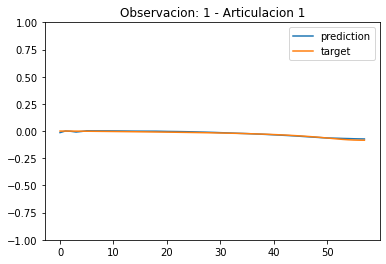

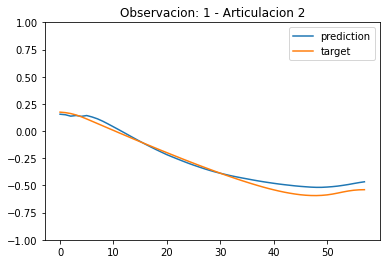

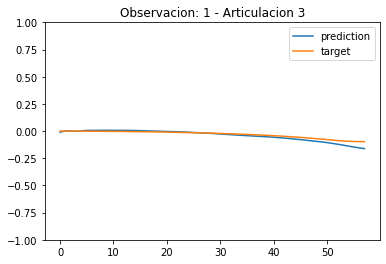

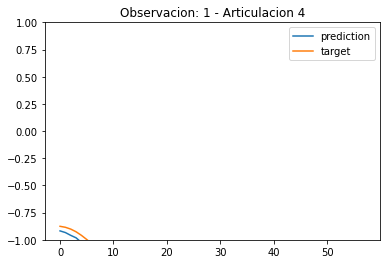

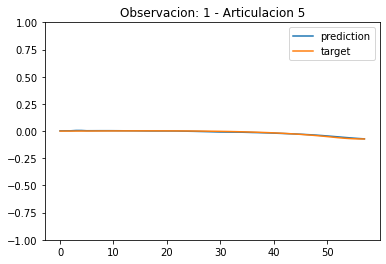

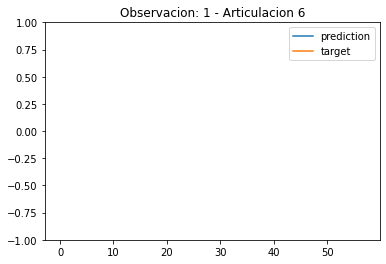

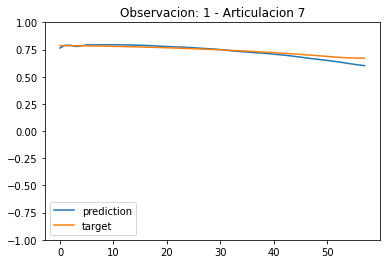

RMSE: 0.7084432170756709


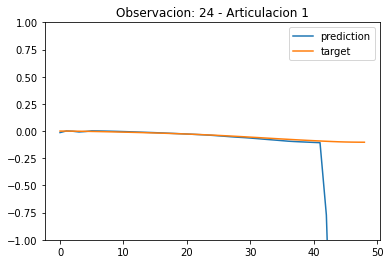

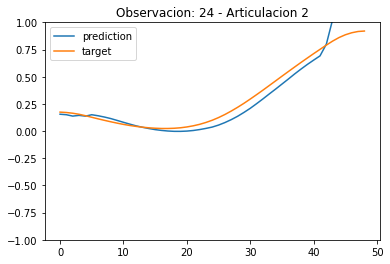

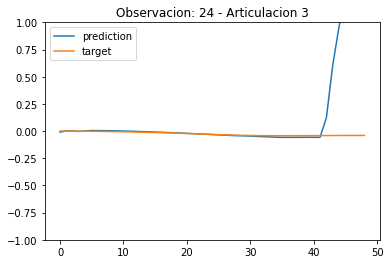

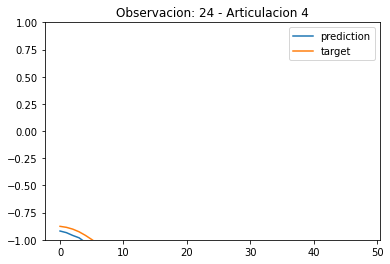

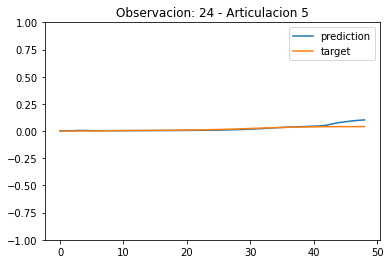

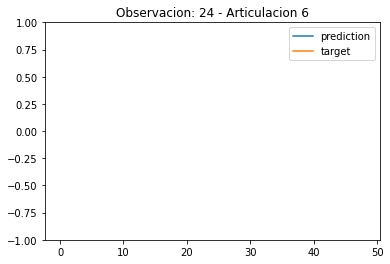

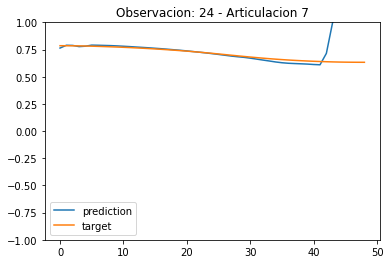

RMSE: 0.019730601835500607


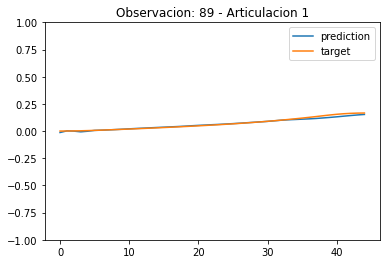

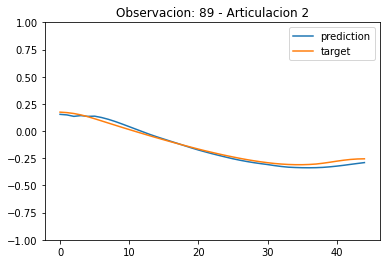

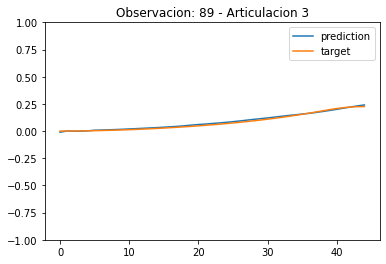

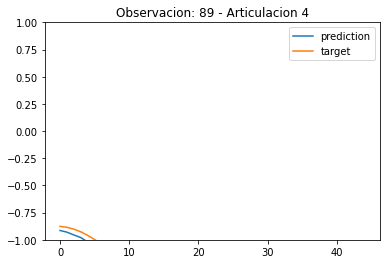

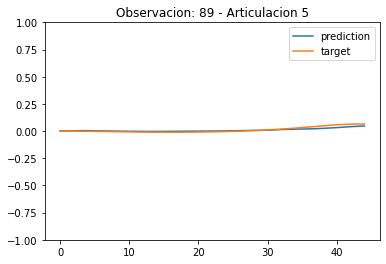

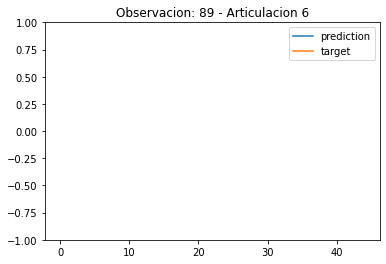

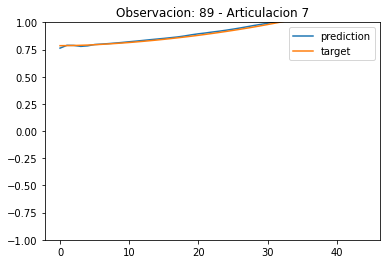

DATOS DEL MODELO:
 - Numero de Epoch: 15
 - RMSE: 0.10357554968450507


MultiImage(
  (fe): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [14]:
# Clases para mas de una imagen

class ObsActionGetter(object):
    """
    Generic class that return the image and the action given an index
    """
    def __init__(self, carpeta_imagenes, archivo_acciones, tam_pruebas):
        # TODO: get a list of all image files
        self.archivo_acciones = archivo_acciones
        self.carpeta_imagenes = carpeta_imagenes
        self.tam_pruebas = tam_pruebas
        path, dirs, files = next(os.walk(self.carpeta_imagenes))
        self.image_files = list(range(len(files)))
        # TODO: get all made actions
        self.actions = []
        
    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.carpeta_imagenes + "Overhead_rgb/"), '*.png'))
        
    def __getitem__(self, idx):
        path_1 = self.carpeta_imagenes + "Front_rgb/" + str(idx) + ".png"
        path_2 = self.carpeta_imagenes + "Left_rgb/" + str(idx) + ".png"
        #path_3 = self.carpeta_imagenes + "Left_rgb/" + str(idx) + ".png"
        #path_4 = self.carpeta_imagenes + "Right_rgb/" + str(idx) + ".png"
        #path_5 = self.carpeta_imagenes + "Wrist_rgb/" + str(idx) + ".png"
        
        im1 = np.array(Image.open(path_1))
        im2 = np.array(Image.open(path_2))
        #im3 = np.array(Image.open(path_3))
        #im4 = np.array(Image.open(path_4))
        #im5 = np.array(Image.open(path_5))
        
        if (idx in self.tam_pruebas):
            im6 = np.array(Image.open(path_1))
            im7 = np.array(Image.open(path_2))
            #im8 = np.array(Image.open(path_3))
            #im9 = np.array(Image.open(path_4))
            #im10 = np.array(Image.open(path_5))
            
        else :
            path_6 = self.carpeta_imagenes + "Front_rgb/" + str(idx-1) + ".png"
            path_7 = self.carpeta_imagenes + "Left_rgb/" + str(idx-1) + ".png"
            #path_8 = self.carpeta_imagenes + "Left_rgb/" + str(idx-1) + ".png"
            #path_9 = self.carpeta_imagenes + "Right_rgb/" + str(idx-1) + ".png"
            #path_10 = self.carpeta_imagenes + "Wrist_rgb/" + str(idx-1) + ".png"
            
            im6 = np.array(Image.open(path_6))
            im7 = np.array(Image.open(path_7))
            #im8 = np.array(Image.open(path_8))
            #im9 = np.array(Image.open(path_9))
            #im10 = np.array(Image.open(path_10))
            
        
        # TODO: get the action
        data = pd.read_csv(self.archivo_acciones, header = 0)
        action = np.float32(np.array(data.iloc[idx]))
        
        if (idx in self.tam_pruebas):
            action_prev_1 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_2 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-1) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-2) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-3) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-4) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        else:
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.float32(np.array(data.iloc[idx-5]))
        
        '''
        im_actual = np.concatenate((im1, im2, im3, im4, im5), axis=2)
        im_previa = np.concatenate((im6, im7, im8, im9, im10), axis=2)
        imagen = np.concatenate((im_actual, im_previa), axis=2) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        '''
        # Return both image and action
        return im1, im2, im6, im7, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5

class ObsActionDataset(Dataset):
    """
    PyTorch Dataset for getting the data. In this case, from ObsActionGetter object
    """
    def __init__(self, obs_action_getter: ObsActionGetter, transformations: List[Callable]):
        super(ObsActionDataset, self).__init__()
        self.obs_action_getter = obs_action_getter
        self.transformations = transformations
        
    def __len__(self):
        return len(self.obs_action_getter)
    
    def __getitem__(self, idx):
        im1, im2, im6, im7, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5 = self.obs_action_getter[idx]
        for t in self.transformations:
            im1 = t(im1)
            im2 = t(im2)
            #im3 = t(im3)
            #im4 = t(im4)
            #im5 = t(im5)
            im6 = t(im6)
            im7 = t(im7)
            #im8 = t(im8)
            #im9 = t(im9)
            #im10 = t(im10)

        # Return both image and action
        im_t = torch.cat((im1, im2), dim=0)
        im_prev_1 = torch.cat((im6, im7), dim=0)
        imagen = torch.cat((im_t, im_prev_1), dim=0) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        
        # Return both image and action
        return (imagen, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5), action
    
class MultiImage(nn.Module):
    def __init__(self, fe, clf):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x1, x2, x3, x4, x5, x6 = x

        f1 = self.flatten(self.avg_pool(self.fe(x1)))
        f = torch.cat((f1, x2, x3, x4, x5, x6), dim=1)
        return self.clf(f)

# Para mas de una imagen

# Create train Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

train_obs_action_getter = ObsActionGetter('Train_dataset/', 'Train_dataset/Train_Actions_P.csv', tamPruebasTrain)
train_dataset = ObsActionDataset(train_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean),
                                                         (std))
                                ])

# Create test Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

test_obs_action_getter = ObsActionGetter('Test_dataset/', 'Test_dataset/Test_Actions_P.csv', tamPruebasTest)
test_dataset = ObsActionDataset(test_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean),
                                                         (std))
                                ])

# Create loaders (class that groups examples in batches)
# Uriz: train DataLoader should have shuffle to True
# Uriz: test DataLoader should have drop_last to False
# Uriz: use more workers to improve the training speed (load data in sever CPU threads). Otherwise we have a CPU -> GPU bottleneck
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=16)

print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))

RMSE_List = []
Model_List = []
Prediction_List = []
Label_List = []
LR_List = []
Loss_List = []

Epoch_List = [15]
num = len(os.listdir("../../tb_logs/my_model2"))
for eps in Epoch_List:
    
    # 1 - Se genera la red
    
    # To pretrain
    model = models.resnet18(pretrained=False)

    # Change the first convolution
    new_conv = torch.nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = list(model.children())[1:]
    model = [new_conv] + model
    model = torch.nn.Sequential(*model)

    # Get only the feature extractor (remove avgpool and fc layers)
    fe = nn.Sequential(*list(model.children())[:-2])

    fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

    # Create custom head
    head_clf = nn.Sequential(
    nn.BatchNorm1d(512+7*5),
    nn.Dropout(0.25),
    nn.Linear(512+7*5, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
    )

    # Rebuild the model
    model = MultiImage(fe, head_clf)
    
    # 2 - Se busca el mejor Learning Rate a aplicar como maximo posible
    
    # Loss function
    criterion = nn.MSELoss()

    # We catch the optimizer of our lit_model
    # optimizer, lr_scheduler = pl_model.configure_optimizers()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Learning State Finder
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

    # Create trainer class
    try:
        BEST_LR = lr_finder.plot()[1]
    except:
        BEST_LR = 5.0E-03
    print(BEST_LR)
    
    if BEST_LR > 0.09:
        BEST_LR = 5.0E-03

    # 3 - Se prepara el Trainer y se entrena con el modelo LitModel
    
    # Number of iterations for LR Schedule
    ITERATIONS_PER_EPOCH = len(train_loader)
    
    logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model2")

    # Create PytorchLighting model for training
    pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * eps, lr=BEST_LR)

    NUM_GPUS = 1 if torch.cuda.is_available() else 0
    
    # Create trainer class
    trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                         log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)

    print("EPOCH NUMERO: " + str(eps))
    
    # Train the model
    trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)
    
    erroresTrainEpoch=[]
    erroresValEpoch=[]
    erroresTrainStep=[]
    erroresValStep=[]
    
    PATH_TB = os.listdir("../../tb_logs/my_model2/version_" + str(num))[1]
    PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model2/version_" + str(num) + "/"
    path_to_events_file = PATH + PATH_TB
    num = num + 1
    
    # Plot de LOSS 
    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            if v.tag == 'training_loss_epoch':
                erroresTrainEpoch.append(v.simple_value)
            if v.tag == 'valid_loss_epoch':
                erroresValEpoch.append(v.simple_value)

            if v.tag == 'training_loss_step':
                erroresTrainStep.append(v.simple_value)
            #if v.tag == 'valid_loss_step':
            #    erroresValStep.append(v.simple_value)

    plt.plot(erroresTrainEpoch, label='Train')
    plt.plot(erroresValEpoch, label='Validacion')
    plt.title("Loss de train y validacion por epoch")
    plt.xlabel("Epoch")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()

    plt.plot(erroresTrainStep, label='Train')
    #plt.plot(erroresValStep, label='Validacion')
    plt.title("Loss de train por steps")
    plt.xlabel("Step")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()
    
    # 4 - Se predice el resultado
    
    # Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
    model = model.eval()
    # Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # To concatenate predictions and labels
    predictions = None
    labels = None
    # Surround all for not computing gradients
    with torch.no_grad():
        # Iterate over test dataset
        for x, y in tqdm.notebook.tqdm(test_loader):
            # Move to device
            x1, x2, x3, x4, x5, x6 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            x6 = x6.to(device)
            
            # Predict
            o = model((x1, x2, x3, x4, x5, x6))
            # Concatenate
            if predictions is None:
                predictions = o
            else:
                predictions = torch.cat((predictions, o), axis=0)

            if labels is None:
                labels = y
            else:
                labels = torch.cat((labels, y), axis=0)

        # Move predictions to CPU and to numpy
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

    mse = sklearn.metrics.mean_squared_error(labels, predictions)
    rmse = sqrt(mse)
    
    print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
    print("El valor RMSE es igual a " + str(rmse))

    # 5 - Se guardan los resultados 
    
    RMSE_List.append(rmse)
    Model_List.append(model)
    Prediction_List.append(predictions)
    Label_List.append(labels)
    LR_List.append(BEST_LR)
    #Loss_List.append(lr_finder.history['loss'][lr_finder.history['lr'].index(BEST_LR)])
    
    print(RMSE_List)

print("Num Epochs mejor prueba: "+str(Epoch_List[RMSE_List.index(min(RMSE_List))]))
print("RMSE mejor prueba: "+str(RMSE_List[RMSE_List.index(min(RMSE_List))]))
print("")

labels = Label_List[(RMSE_List.index(min(RMSE_List)))]
predictions = Prediction_List[(RMSE_List.index(min(RMSE_List)))]

# Error promedio de cada una de las articulaciones
joint_error = np.zeros(7)
minimo = np.zeros(7)
maximo = np.zeros(7)
for i in range(7):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print("Error total por articulacion: "+str(joint_error))

for i in range(7):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")
    
'''    
for i in range(7):
    plt.plot(predictions[0:50, i], label='prediction')
    plt.plot(labels[0:50, i], label='target')
    plt.xlabel('Pruebas')
    plt.ylabel('Valor Accion')
    plt.title('Articulacion ' + str(i+1))
    plt.legend(['Prediction','Target'])
    plt.show()
'''    
print("")
try:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '*.csv')

    ordenado=[]
    for i in observaciones:
        if i.split(".")[0].split("_")[1]!="Actions":
            ordenado.append(int(i.split(".")[0].split("_")[1]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
except:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '0_V*')

    ordenado=[]
    for i in observaciones:
        ordenado.append(int(i.split(".")[0].split("_")[2]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_V_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
print("")

#MSE por demostracion
mseDem=[]
rmseDem=[]
for j in range(len(tamPruebas)-1):
    mseDem.append(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]]))
    rmseDem.append(sqrt(mseDem[j]))
''' 
print("Los valores del error cudratico medios (MSE) por demostracion son igual a "+str(mseDem[0:5]))
print("El valor medio de MSE es "+str(np.mean(mseDem)))
print("El valor maximo de MSE es "+str(max(mseDem))+" y equivale a la prueba "+str(np.argmax(mseDem)))
print("El valor minimo de MSE es "+str(min(mseDem))+" y equivale a la prueba "+str(np.argmin(mseDem)))
mMSE=sorted(mseDem)[0:5]
print("Mejores MSE: "+str(mMSE))
print("Mejores pruebas: "+str(mseDem.index(mMSE[0]))+", "+str(mseDem.index(mMSE[1]))+", "+str(mseDem.index(mMSE[2]))+", "+str(mseDem.index(mMSE[3]))+", "+str(mseDem.index(mMSE[4])))
pMSE=sorted(mseDem,reverse=True)[0:5]
print("Peores MSE: "+str(pMSE))
print("Peores pruebas: "+str(mseDem.index(pMSE[0]))+", "+str(mseDem.index(pMSE[1]))+", "+str(mseDem.index(pMSE[2]))+", "+str(mseDem.index(pMSE[3]))+", "+str(mseDem.index(pMSE[4])))

print("")
'''
print("Los valores RMSE por demostracion son igual a "+str(rmseDem[0:5]))
print("El valor medio de RMSE es "+str(np.mean(rmseDem)))
print("El valor maximo de RMSE es "+str(max(rmseDem))+" y equivale a la prueba "+str(np.argmax(rmseDem)))
print("El valor minimo de RMSE es "+str(min(rmseDem))+" y equivale a la prueba "+str(np.argmin(rmseDem)))
print("")
mRMSE=sorted(rmseDem)[0:5]
print("Mejores RMSE: "+str(mRMSE))
print("Mejores pruebas: "+str(rmseDem.index(mRMSE[0]))+", "+str(rmseDem.index(mRMSE[1]))+", "+str(rmseDem.index(mRMSE[2]))+", "+str(rmseDem.index(mRMSE[3]))+", "+str(rmseDem.index(mRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(mRMSE[0])])+", "+str(tamPruebas[rmseDem.index(mRMSE[1])])+", "+str(tamPruebas[rmseDem.index(mRMSE[2])])+", "+str(tamPruebas[rmseDem.index(mRMSE[3])])+", "+str(tamPruebas[rmseDem.index(mRMSE[4])]))
print("")
pRMSE=sorted(rmseDem,reverse=True)[0:5]
print("Peores RMSE: "+str(pRMSE))
print("Peores pruebas: "+str(rmseDem.index(pRMSE[0]))+", "+str(rmseDem.index(pRMSE[1]))+", "+str(rmseDem.index(pRMSE[2]))+", "+str(rmseDem.index(pRMSE[3]))+", "+str(rmseDem.index(pRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(pRMSE[0])])+", "+str(tamPruebas[rmseDem.index(pRMSE[1])])+", "+str(tamPruebas[rmseDem.index(pRMSE[2])])+", "+str(tamPruebas[rmseDem.index(pRMSE[3])])+", "+str(tamPruebas[rmseDem.index(pRMSE[4])]))
print("")

#Ploteamos la primera prueba
j=1
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la peor prueba
j=np.argmax(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la mejor prueba
j=np.argmin(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()

print("DATOS DEL MODELO:")
print(" - Numero de Epoch: " + str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]))
print(" - RMSE: " + str(min(RMSE_List)))
name = 'RLBench_' + str(round(min(RMSE_List),3)) + '-5_P_Front+Left'
torch.save(Model_List[(RMSE_List.index(min(RMSE_List)))], name)
model = torch.load(name)
model.eval()

# Start
## Front + Right P

35999
1124
8806
276


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.70E-03


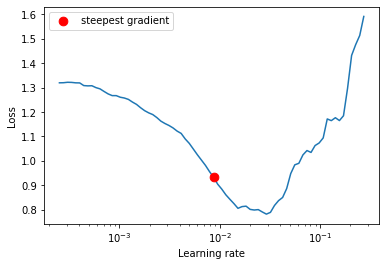

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
295 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.964    Total estimated model params size (MB)


0.008697490026177835
EPOCH NUMERO: 15


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

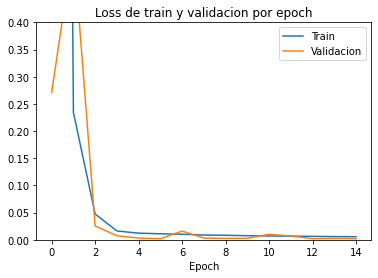

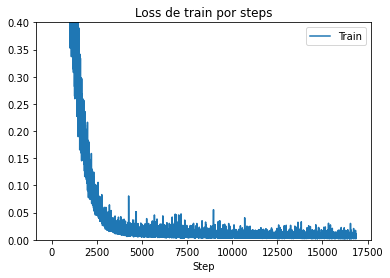

  0%|          | 0/276 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.0020382085
El valor RMSE es igual a 0.04514652295516319
[0.04514652295516319]
Num Epochs mejor prueba: 15
RMSE mejor prueba: 0.04514652295516319

Error total por articulacion: [0.01317469 0.04930407 0.01083998 0.07629838 0.02376305 0.06976619
 0.01708898]
Articulacion 0 [-0.34 - 0.39] 0.73 1.8%
Articulacion 1 [-0.69 - 1.1] 1.79 2.75%
Articulacion 2 [-0.38 - 0.47] 0.85 1.28%
Articulacion 3 [-3.05 - -0.74] 2.31 3.3%
Articulacion 4 [-0.28 - 0.22] 0.5 4.75%
Articulacion 5 [1.22 - 3.03] 1.81 3.85%
Articulacion 6 [0.06 - 1.64] 1.58 1.08%


Los valores RMSE por demostracion son igual a [0.030288864442757312, 0.07236858070520764, 0.028653534730876257, 0.06678735542503043, 0.04260372225804385]
El valor medio de RMSE es 0.04186279106835124
El valor maximo de RMSE es 0.10615111738968745 y equivale a la prueba 17
El valor minimo de RMSE es 0.019518359967342306 y equivale a la prueba 132

Mejores RMSE: [0.019518359967342306, 0.02001377275849505

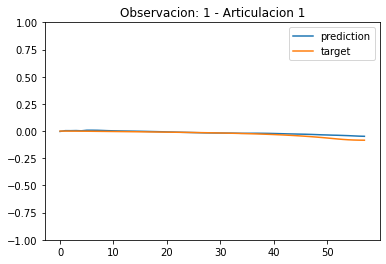

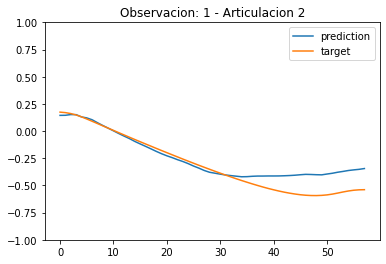

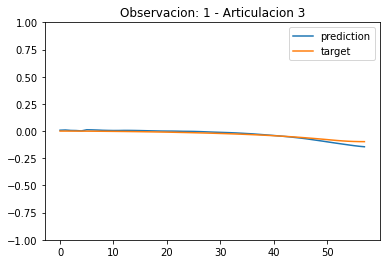

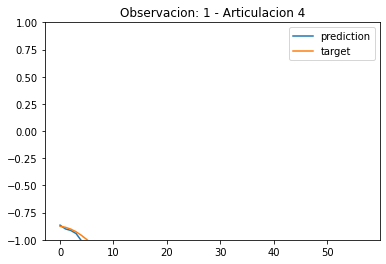

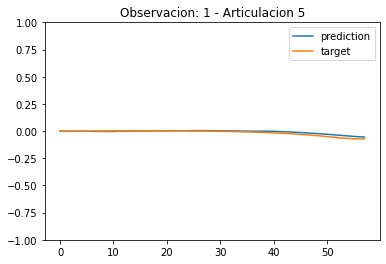

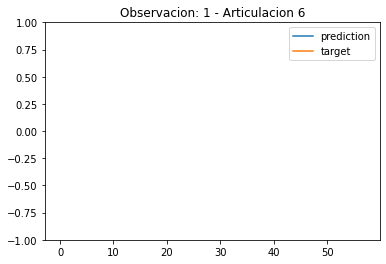

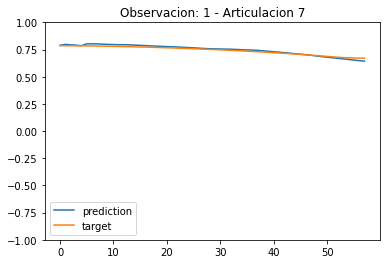

RMSE: 0.10615111738968745


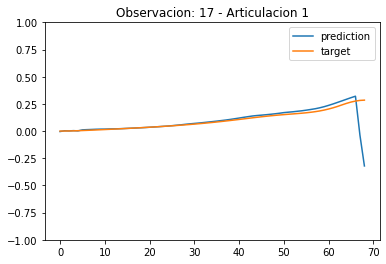

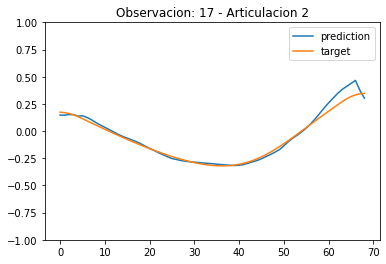

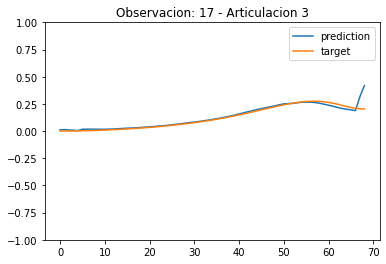

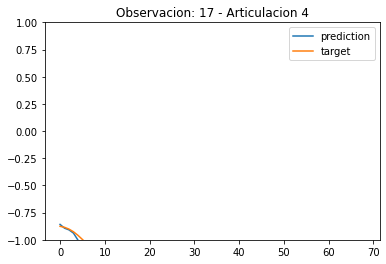

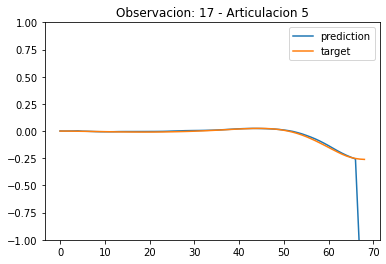

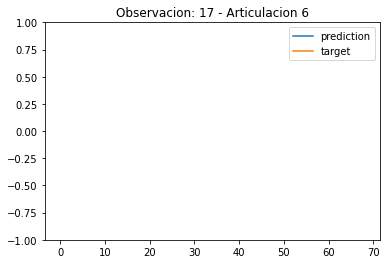

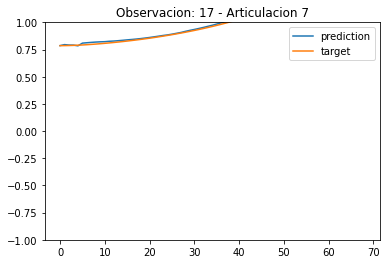

RMSE: 0.019518359967342306


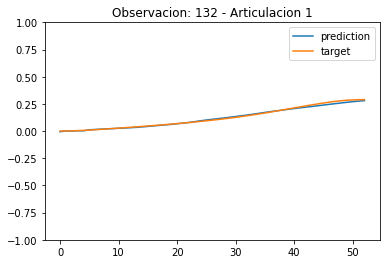

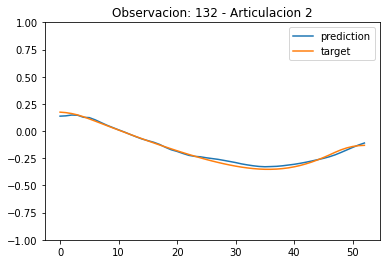

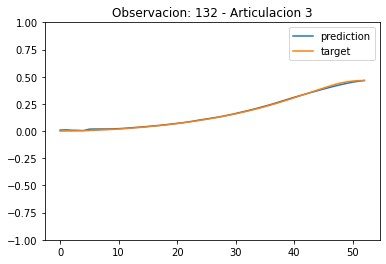

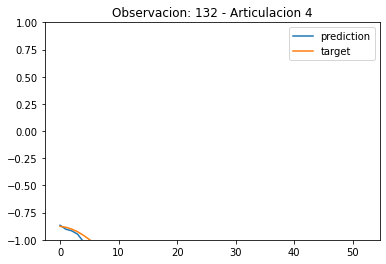

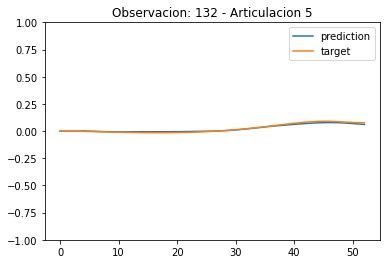

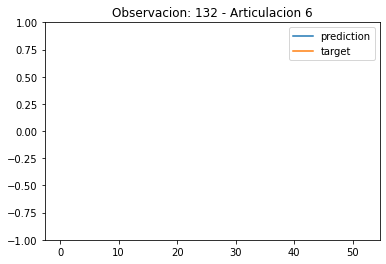

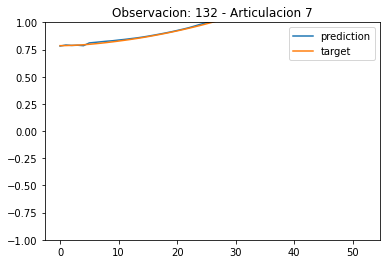

DATOS DEL MODELO:
 - Numero de Epoch: 15
 - RMSE: 0.04514652295516319


MultiImage(
  (fe): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [15]:
# Clases para mas de una imagen

class ObsActionGetter(object):
    """
    Generic class that return the image and the action given an index
    """
    def __init__(self, carpeta_imagenes, archivo_acciones, tam_pruebas):
        # TODO: get a list of all image files
        self.archivo_acciones = archivo_acciones
        self.carpeta_imagenes = carpeta_imagenes
        self.tam_pruebas = tam_pruebas
        path, dirs, files = next(os.walk(self.carpeta_imagenes))
        self.image_files = list(range(len(files)))
        # TODO: get all made actions
        self.actions = []
        
    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.carpeta_imagenes + "Overhead_rgb/"), '*.png'))
        
    def __getitem__(self, idx):
        path_1 = self.carpeta_imagenes + "Front_rgb/" + str(idx) + ".png"
        path_2 = self.carpeta_imagenes + "Right_rgb/" + str(idx) + ".png"
        #path_3 = self.carpeta_imagenes + "Left_rgb/" + str(idx) + ".png"
        #path_4 = self.carpeta_imagenes + "Right_rgb/" + str(idx) + ".png"
        #path_5 = self.carpeta_imagenes + "Wrist_rgb/" + str(idx) + ".png"
        
        im1 = np.array(Image.open(path_1))
        im2 = np.array(Image.open(path_2))
        #im3 = np.array(Image.open(path_3))
        #im4 = np.array(Image.open(path_4))
        #im5 = np.array(Image.open(path_5))
        
        if (idx in self.tam_pruebas):
            im6 = np.array(Image.open(path_1))
            im7 = np.array(Image.open(path_2))
            #im8 = np.array(Image.open(path_3))
            #im9 = np.array(Image.open(path_4))
            #im10 = np.array(Image.open(path_5))
            
        else :
            path_6 = self.carpeta_imagenes + "Front_rgb/" + str(idx-1) + ".png"
            path_7 = self.carpeta_imagenes + "Right_rgb/" + str(idx-1) + ".png"
            #path_8 = self.carpeta_imagenes + "Left_rgb/" + str(idx-1) + ".png"
            #path_9 = self.carpeta_imagenes + "Right_rgb/" + str(idx-1) + ".png"
            #path_10 = self.carpeta_imagenes + "Wrist_rgb/" + str(idx-1) + ".png"
            
            im6 = np.array(Image.open(path_6))
            im7 = np.array(Image.open(path_7))
            #im8 = np.array(Image.open(path_8))
            #im9 = np.array(Image.open(path_9))
            #im10 = np.array(Image.open(path_10))
            
        
        # TODO: get the action
        data = pd.read_csv(self.archivo_acciones, header = 0)
        action = np.float32(np.array(data.iloc[idx]))
        
        if (idx in self.tam_pruebas):
            action_prev_1 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_2 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-1) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-2) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-3) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-4) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        else:
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.float32(np.array(data.iloc[idx-5]))
        
        '''
        im_actual = np.concatenate((im1, im2, im3, im4, im5), axis=2)
        im_previa = np.concatenate((im6, im7, im8, im9, im10), axis=2)
        imagen = np.concatenate((im_actual, im_previa), axis=2) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        '''
        # Return both image and action
        return im1, im2, im6, im7, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5

class ObsActionDataset(Dataset):
    """
    PyTorch Dataset for getting the data. In this case, from ObsActionGetter object
    """
    def __init__(self, obs_action_getter: ObsActionGetter, transformations: List[Callable]):
        super(ObsActionDataset, self).__init__()
        self.obs_action_getter = obs_action_getter
        self.transformations = transformations
        
    def __len__(self):
        return len(self.obs_action_getter)
    
    def __getitem__(self, idx):
        im1, im2, im6, im7, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5 = self.obs_action_getter[idx]
        for t in self.transformations:
            im1 = t(im1)
            im2 = t(im2)
            #im3 = t(im3)
            #im4 = t(im4)
            #im5 = t(im5)
            im6 = t(im6)
            im7 = t(im7)
            #im8 = t(im8)
            #im9 = t(im9)
            #im10 = t(im10)

        # Return both image and action
        im_t = torch.cat((im1, im2), dim=0)
        im_prev_1 = torch.cat((im6, im7), dim=0)
        imagen = torch.cat((im_t, im_prev_1), dim=0) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        
        # Return both image and action
        return (imagen, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5), action
    
class MultiImage(nn.Module):
    def __init__(self, fe, clf):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x1, x2, x3, x4, x5, x6 = x

        f1 = self.flatten(self.avg_pool(self.fe(x1)))
        f = torch.cat((f1, x2, x3, x4, x5, x6), dim=1)
        return self.clf(f)

# Para mas de una imagen

# Create train Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

train_obs_action_getter = ObsActionGetter('Train_dataset/', 'Train_dataset/Train_Actions_P.csv', tamPruebasTrain)
train_dataset = ObsActionDataset(train_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean),
                                                         (std))
                                ])

# Create test Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

test_obs_action_getter = ObsActionGetter('Test_dataset/', 'Test_dataset/Test_Actions_P.csv', tamPruebasTest)
test_dataset = ObsActionDataset(test_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean),
                                                         (std))
                                ])

# Create loaders (class that groups examples in batches)
# Uriz: train DataLoader should have shuffle to True
# Uriz: test DataLoader should have drop_last to False
# Uriz: use more workers to improve the training speed (load data in sever CPU threads). Otherwise we have a CPU -> GPU bottleneck
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=16)

print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))

RMSE_List = []
Model_List = []
Prediction_List = []
Label_List = []
LR_List = []
Loss_List = []

Epoch_List = [15]
num = len(os.listdir("../../tb_logs/my_model2"))
for eps in Epoch_List:
    
    # 1 - Se genera la red
    
    # To pretrain
    model = models.resnet18(pretrained=False)

    # Change the first convolution
    new_conv = torch.nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = list(model.children())[1:]
    model = [new_conv] + model
    model = torch.nn.Sequential(*model)

    # Get only the feature extractor (remove avgpool and fc layers)
    fe = nn.Sequential(*list(model.children())[:-2])

    fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

    # Create custom head
    head_clf = nn.Sequential(
    nn.BatchNorm1d(512+7*5),
    nn.Dropout(0.25),
    nn.Linear(512+7*5, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
    )

    # Rebuild the model
    model = MultiImage(fe, head_clf)
    
    # 2 - Se busca el mejor Learning Rate a aplicar como maximo posible
    
    # Loss function
    criterion = nn.MSELoss()

    # We catch the optimizer of our lit_model
    # optimizer, lr_scheduler = pl_model.configure_optimizers()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Learning State Finder
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

    # Create trainer class
    try:
        BEST_LR = lr_finder.plot()[1]
    except:
        BEST_LR = 5.0E-03
    print(BEST_LR)
    
    if BEST_LR > 0.09:
        BEST_LR = 5.0E-03

    # 3 - Se prepara el Trainer y se entrena con el modelo LitModel
    
    # Number of iterations for LR Schedule
    ITERATIONS_PER_EPOCH = len(train_loader)
    
    logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model2")

    # Create PytorchLighting model for training
    pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * eps, lr=BEST_LR)

    NUM_GPUS = 1 if torch.cuda.is_available() else 0
    
    # Create trainer class
    trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                         log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)

    print("EPOCH NUMERO: " + str(eps))
    
    # Train the model
    trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)
    
    erroresTrainEpoch=[]
    erroresValEpoch=[]
    erroresTrainStep=[]
    erroresValStep=[]
    
    PATH_TB = os.listdir("../../tb_logs/my_model2/version_" + str(num))[1]
    PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model2/version_" + str(num) + "/"
    path_to_events_file = PATH + PATH_TB
    num = num + 1
    
    # Plot de LOSS 
    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            if v.tag == 'training_loss_epoch':
                erroresTrainEpoch.append(v.simple_value)
            if v.tag == 'valid_loss_epoch':
                erroresValEpoch.append(v.simple_value)

            if v.tag == 'training_loss_step':
                erroresTrainStep.append(v.simple_value)
            #if v.tag == 'valid_loss_step':
            #    erroresValStep.append(v.simple_value)

    plt.plot(erroresTrainEpoch, label='Train')
    plt.plot(erroresValEpoch, label='Validacion')
    plt.title("Loss de train y validacion por epoch")
    plt.xlabel("Epoch")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()

    plt.plot(erroresTrainStep, label='Train')
    #plt.plot(erroresValStep, label='Validacion')
    plt.title("Loss de train por steps")
    plt.xlabel("Step")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()
    
    # 4 - Se predice el resultado
    
    # Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
    model = model.eval()
    # Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # To concatenate predictions and labels
    predictions = None
    labels = None
    # Surround all for not computing gradients
    with torch.no_grad():
        # Iterate over test dataset
        for x, y in tqdm.notebook.tqdm(test_loader):
            # Move to device
            x1, x2, x3, x4, x5, x6 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            x6 = x6.to(device)
            
            # Predict
            o = model((x1, x2, x3, x4, x5, x6))
            # Concatenate
            if predictions is None:
                predictions = o
            else:
                predictions = torch.cat((predictions, o), axis=0)

            if labels is None:
                labels = y
            else:
                labels = torch.cat((labels, y), axis=0)

        # Move predictions to CPU and to numpy
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

    mse = sklearn.metrics.mean_squared_error(labels, predictions)
    rmse = sqrt(mse)
    
    print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
    print("El valor RMSE es igual a " + str(rmse))

    # 5 - Se guardan los resultados 
    
    RMSE_List.append(rmse)
    Model_List.append(model)
    Prediction_List.append(predictions)
    Label_List.append(labels)
    LR_List.append(BEST_LR)
    #Loss_List.append(lr_finder.history['loss'][lr_finder.history['lr'].index(BEST_LR)])
    
    print(RMSE_List)

print("Num Epochs mejor prueba: "+str(Epoch_List[RMSE_List.index(min(RMSE_List))]))
print("RMSE mejor prueba: "+str(RMSE_List[RMSE_List.index(min(RMSE_List))]))
print("")

labels = Label_List[(RMSE_List.index(min(RMSE_List)))]
predictions = Prediction_List[(RMSE_List.index(min(RMSE_List)))]

# Error promedio de cada una de las articulaciones
joint_error = np.zeros(7)
minimo = np.zeros(7)
maximo = np.zeros(7)
for i in range(7):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print("Error total por articulacion: "+str(joint_error))

for i in range(7):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")
    
'''    
for i in range(7):
    plt.plot(predictions[0:50, i], label='prediction')
    plt.plot(labels[0:50, i], label='target')
    plt.xlabel('Pruebas')
    plt.ylabel('Valor Accion')
    plt.title('Articulacion ' + str(i+1))
    plt.legend(['Prediction','Target'])
    plt.show()
'''    
print("")
try:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '*.csv')

    ordenado=[]
    for i in observaciones:
        if i.split(".")[0].split("_")[1]!="Actions":
            ordenado.append(int(i.split(".")[0].split("_")[1]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
except:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '0_V*')

    ordenado=[]
    for i in observaciones:
        ordenado.append(int(i.split(".")[0].split("_")[2]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_V_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
print("")

#MSE por demostracion
mseDem=[]
rmseDem=[]
for j in range(len(tamPruebas)-1):
    mseDem.append(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]]))
    rmseDem.append(sqrt(mseDem[j]))
''' 
print("Los valores del error cudratico medios (MSE) por demostracion son igual a "+str(mseDem[0:5]))
print("El valor medio de MSE es "+str(np.mean(mseDem)))
print("El valor maximo de MSE es "+str(max(mseDem))+" y equivale a la prueba "+str(np.argmax(mseDem)))
print("El valor minimo de MSE es "+str(min(mseDem))+" y equivale a la prueba "+str(np.argmin(mseDem)))
mMSE=sorted(mseDem)[0:5]
print("Mejores MSE: "+str(mMSE))
print("Mejores pruebas: "+str(mseDem.index(mMSE[0]))+", "+str(mseDem.index(mMSE[1]))+", "+str(mseDem.index(mMSE[2]))+", "+str(mseDem.index(mMSE[3]))+", "+str(mseDem.index(mMSE[4])))
pMSE=sorted(mseDem,reverse=True)[0:5]
print("Peores MSE: "+str(pMSE))
print("Peores pruebas: "+str(mseDem.index(pMSE[0]))+", "+str(mseDem.index(pMSE[1]))+", "+str(mseDem.index(pMSE[2]))+", "+str(mseDem.index(pMSE[3]))+", "+str(mseDem.index(pMSE[4])))

print("")
'''
print("Los valores RMSE por demostracion son igual a "+str(rmseDem[0:5]))
print("El valor medio de RMSE es "+str(np.mean(rmseDem)))
print("El valor maximo de RMSE es "+str(max(rmseDem))+" y equivale a la prueba "+str(np.argmax(rmseDem)))
print("El valor minimo de RMSE es "+str(min(rmseDem))+" y equivale a la prueba "+str(np.argmin(rmseDem)))
print("")
mRMSE=sorted(rmseDem)[0:5]
print("Mejores RMSE: "+str(mRMSE))
print("Mejores pruebas: "+str(rmseDem.index(mRMSE[0]))+", "+str(rmseDem.index(mRMSE[1]))+", "+str(rmseDem.index(mRMSE[2]))+", "+str(rmseDem.index(mRMSE[3]))+", "+str(rmseDem.index(mRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(mRMSE[0])])+", "+str(tamPruebas[rmseDem.index(mRMSE[1])])+", "+str(tamPruebas[rmseDem.index(mRMSE[2])])+", "+str(tamPruebas[rmseDem.index(mRMSE[3])])+", "+str(tamPruebas[rmseDem.index(mRMSE[4])]))
print("")
pRMSE=sorted(rmseDem,reverse=True)[0:5]
print("Peores RMSE: "+str(pRMSE))
print("Peores pruebas: "+str(rmseDem.index(pRMSE[0]))+", "+str(rmseDem.index(pRMSE[1]))+", "+str(rmseDem.index(pRMSE[2]))+", "+str(rmseDem.index(pRMSE[3]))+", "+str(rmseDem.index(pRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(pRMSE[0])])+", "+str(tamPruebas[rmseDem.index(pRMSE[1])])+", "+str(tamPruebas[rmseDem.index(pRMSE[2])])+", "+str(tamPruebas[rmseDem.index(pRMSE[3])])+", "+str(tamPruebas[rmseDem.index(pRMSE[4])]))
print("")

#Ploteamos la primera prueba
j=1
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la peor prueba
j=np.argmax(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la mejor prueba
j=np.argmin(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()

print("DATOS DEL MODELO:")
print(" - Numero de Epoch: " + str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]))
print(" - RMSE: " + str(min(RMSE_List)))
name = 'RLBench_' + str(round(min(RMSE_List),3)) + '-5_P_Front+Right'
torch.save(Model_List[(RMSE_List.index(min(RMSE_List)))], name)
model = torch.load(name)
model.eval()

# Start
## Left + Right P

35999
1124
8806
276


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.56E-01


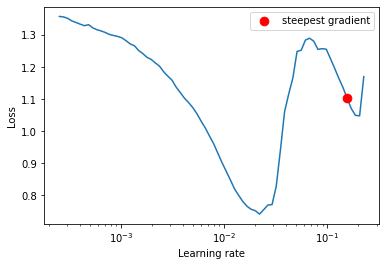

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
295 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.964    Total estimated model params size (MB)


0.15556761439304725
EPOCH NUMERO: 15


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

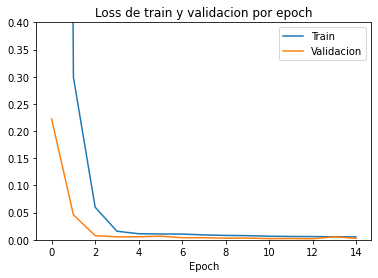

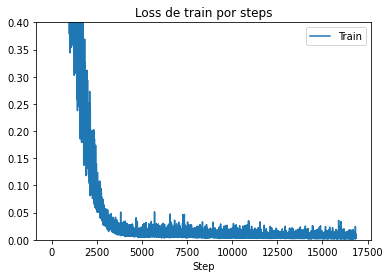

  0%|          | 0/276 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.0026679023
El valor RMSE es igual a 0.05165174024495185
[0.05165174024495185]
Num Epochs mejor prueba: 15
RMSE mejor prueba: 0.05165174024495185

Error total por articulacion: [0.0111214  0.05508743 0.01684446 0.08872059 0.00960829 0.08197518
 0.02344611]
Articulacion 0 [-0.34 - 0.39] 0.73 1.52%
Articulacion 1 [-0.69 - 1.1] 1.79 3.08%
Articulacion 2 [-0.38 - 0.47] 0.85 1.98%
Articulacion 3 [-3.05 - -0.74] 2.31 3.84%
Articulacion 4 [-0.28 - 0.22] 0.5 1.92%
Articulacion 5 [1.22 - 3.03] 1.81 4.53%
Articulacion 6 [0.06 - 1.64] 1.58 1.48%


Los valores RMSE por demostracion son igual a [0.04474482163611162, 0.07336178869068993, 0.051256209868064305, 0.06786958775118765, 0.039535637299206346]
El valor medio de RMSE es 0.049748513620936664
El valor maximo de RMSE es 0.08619336218724896 y equivale a la prueba 20
El valor minimo de RMSE es 0.033825539940013104 y equivale a la prueba 176

Mejores RMSE: [0.033825539940013104, 0.03440701466365

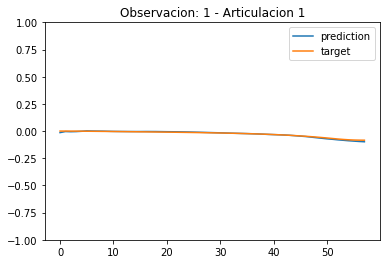

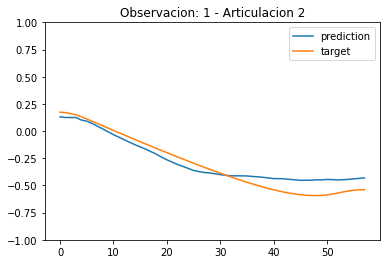

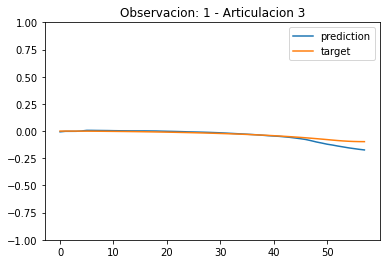

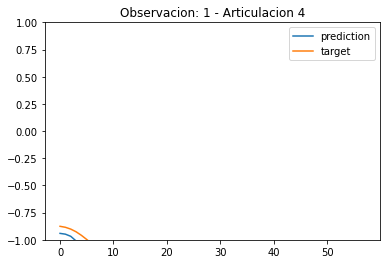

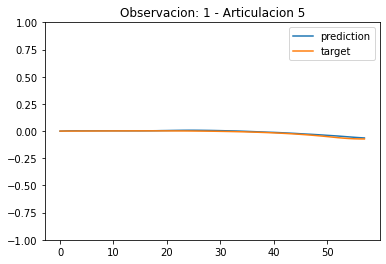

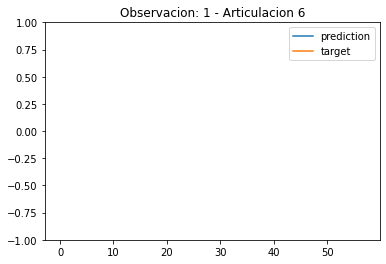

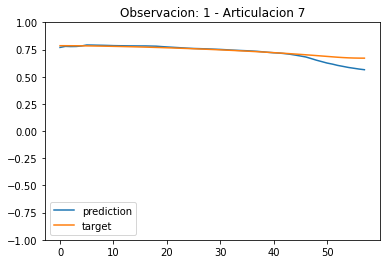

RMSE: 0.08619336218724896


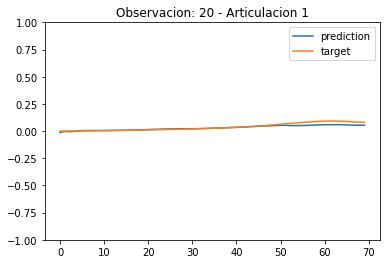

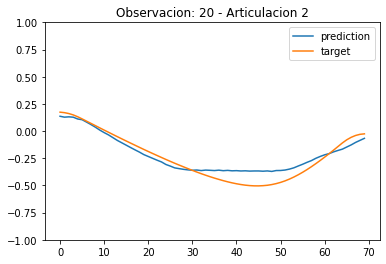

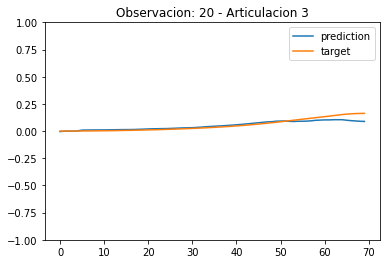

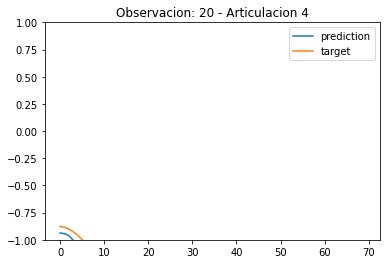

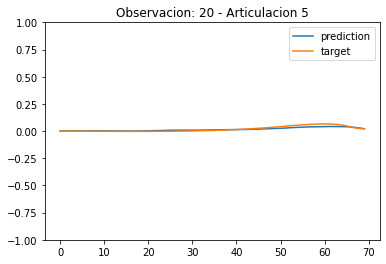

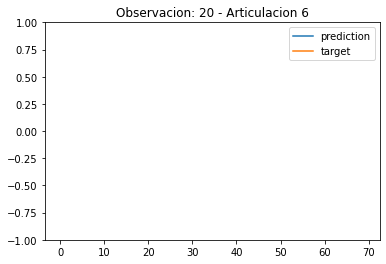

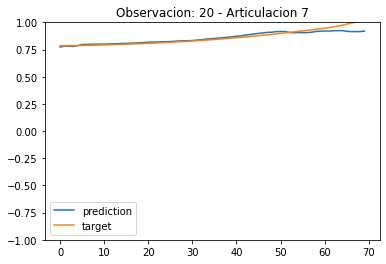

RMSE: 0.033825539940013104


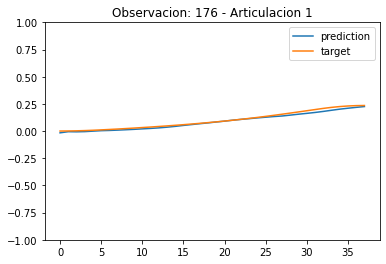

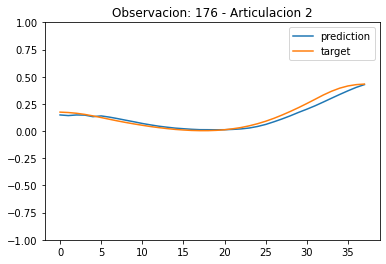

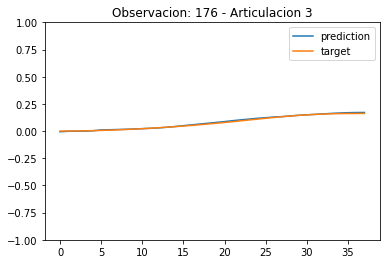

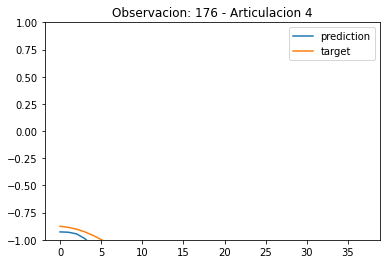

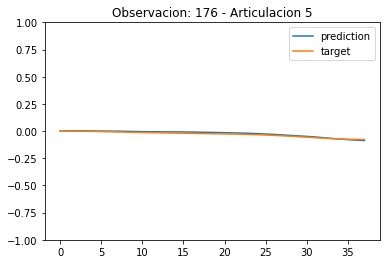

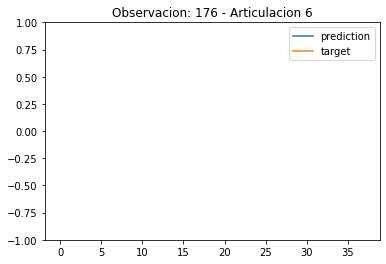

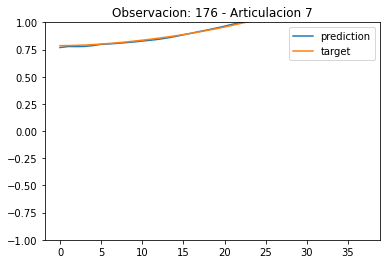

DATOS DEL MODELO:
 - Numero de Epoch: 15
 - RMSE: 0.05165174024495185


MultiImage(
  (fe): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [16]:
# Clases para mas de una imagen

class ObsActionGetter(object):
    """
    Generic class that return the image and the action given an index
    """
    def __init__(self, carpeta_imagenes, archivo_acciones, tam_pruebas):
        # TODO: get a list of all image files
        self.archivo_acciones = archivo_acciones
        self.carpeta_imagenes = carpeta_imagenes
        self.tam_pruebas = tam_pruebas
        path, dirs, files = next(os.walk(self.carpeta_imagenes))
        self.image_files = list(range(len(files)))
        # TODO: get all made actions
        self.actions = []
        
    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.carpeta_imagenes + "Overhead_rgb/"), '*.png'))
        
    def __getitem__(self, idx):
        path_1 = self.carpeta_imagenes + "Left_rgb/" + str(idx) + ".png"
        path_2 = self.carpeta_imagenes + "Right_rgb/" + str(idx) + ".png"
        #path_3 = self.carpeta_imagenes + "Left_rgb/" + str(idx) + ".png"
        #path_4 = self.carpeta_imagenes + "Right_rgb/" + str(idx) + ".png"
        #path_5 = self.carpeta_imagenes + "Wrist_rgb/" + str(idx) + ".png"
        
        im1 = np.array(Image.open(path_1))
        im2 = np.array(Image.open(path_2))
        #im3 = np.array(Image.open(path_3))
        #im4 = np.array(Image.open(path_4))
        #im5 = np.array(Image.open(path_5))
        
        if (idx in self.tam_pruebas):
            im6 = np.array(Image.open(path_1))
            im7 = np.array(Image.open(path_2))
            #im8 = np.array(Image.open(path_3))
            #im9 = np.array(Image.open(path_4))
            #im10 = np.array(Image.open(path_5))
            
        else :
            path_6 = self.carpeta_imagenes + "Left_rgb/" + str(idx-1) + ".png"
            path_7 = self.carpeta_imagenes + "Right_rgb/" + str(idx-1) + ".png"
            #path_8 = self.carpeta_imagenes + "Left_rgb/" + str(idx-1) + ".png"
            #path_9 = self.carpeta_imagenes + "Right_rgb/" + str(idx-1) + ".png"
            #path_10 = self.carpeta_imagenes + "Wrist_rgb/" + str(idx-1) + ".png"
            
            im6 = np.array(Image.open(path_6))
            im7 = np.array(Image.open(path_7))
            #im8 = np.array(Image.open(path_8))
            #im9 = np.array(Image.open(path_9))
            #im10 = np.array(Image.open(path_10))
            
        
        # TODO: get the action
        data = pd.read_csv(self.archivo_acciones, header = 0)
        action = np.float32(np.array(data.iloc[idx]))
        
        if (idx in self.tam_pruebas):
            action_prev_1 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_2 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-1) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-2) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-3) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-4) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        else:
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.float32(np.array(data.iloc[idx-5]))
        
        '''
        im_actual = np.concatenate((im1, im2, im3, im4, im5), axis=2)
        im_previa = np.concatenate((im6, im7, im8, im9, im10), axis=2)
        imagen = np.concatenate((im_actual, im_previa), axis=2) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        '''
        # Return both image and action
        return im1, im2, im6, im7, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5

class ObsActionDataset(Dataset):
    """
    PyTorch Dataset for getting the data. In this case, from ObsActionGetter object
    """
    def __init__(self, obs_action_getter: ObsActionGetter, transformations: List[Callable]):
        super(ObsActionDataset, self).__init__()
        self.obs_action_getter = obs_action_getter
        self.transformations = transformations
        
    def __len__(self):
        return len(self.obs_action_getter)
    
    def __getitem__(self, idx):
        im1, im2, im6, im7, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5 = self.obs_action_getter[idx]
        for t in self.transformations:
            im1 = t(im1)
            im2 = t(im2)
            #im3 = t(im3)
            #im4 = t(im4)
            #im5 = t(im5)
            im6 = t(im6)
            im7 = t(im7)
            #im8 = t(im8)
            #im9 = t(im9)
            #im10 = t(im10)

        # Return both image and action
        im_t = torch.cat((im1, im2), dim=0)
        im_prev_1 = torch.cat((im6, im7), dim=0)
        imagen = torch.cat((im_t, im_prev_1), dim=0) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        
        # Return both image and action
        return (imagen, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5), action
    
class MultiImage(nn.Module):
    def __init__(self, fe, clf):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x1, x2, x3, x4, x5, x6 = x

        f1 = self.flatten(self.avg_pool(self.fe(x1)))
        f = torch.cat((f1, x2, x3, x4, x5, x6), dim=1)
        return self.clf(f)

# Para mas de una imagen

# Create train Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

train_obs_action_getter = ObsActionGetter('Train_dataset/', 'Train_dataset/Train_Actions_P.csv', tamPruebasTrain)
train_dataset = ObsActionDataset(train_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean),
                                                         (std))
                                ])

# Create test Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

test_obs_action_getter = ObsActionGetter('Test_dataset/', 'Test_dataset/Test_Actions_P.csv', tamPruebasTest)
test_dataset = ObsActionDataset(test_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean),
                                                         (std))
                                ])

# Create loaders (class that groups examples in batches)
# Uriz: train DataLoader should have shuffle to True
# Uriz: test DataLoader should have drop_last to False
# Uriz: use more workers to improve the training speed (load data in sever CPU threads). Otherwise we have a CPU -> GPU bottleneck
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=16)

print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))

RMSE_List = []
Model_List = []
Prediction_List = []
Label_List = []
LR_List = []
Loss_List = []

Epoch_List = [15]
num = len(os.listdir("../../tb_logs/my_model2"))
for eps in Epoch_List:
    
    # 1 - Se genera la red
    
    # To pretrain
    model = models.resnet18(pretrained=False)

    # Change the first convolution
    new_conv = torch.nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = list(model.children())[1:]
    model = [new_conv] + model
    model = torch.nn.Sequential(*model)

    # Get only the feature extractor (remove avgpool and fc layers)
    fe = nn.Sequential(*list(model.children())[:-2])

    fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

    # Create custom head
    head_clf = nn.Sequential(
    nn.BatchNorm1d(512+7*5),
    nn.Dropout(0.25),
    nn.Linear(512+7*5, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
    )

    # Rebuild the model
    model = MultiImage(fe, head_clf)
    
    # 2 - Se busca el mejor Learning Rate a aplicar como maximo posible
    
    # Loss function
    criterion = nn.MSELoss()

    # We catch the optimizer of our lit_model
    # optimizer, lr_scheduler = pl_model.configure_optimizers()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Learning State Finder
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

    # Create trainer class
    try:
        BEST_LR = lr_finder.plot()[1]
    except:
        BEST_LR = 5.0E-03
    print(BEST_LR)
    
    if BEST_LR > 0.09:
        BEST_LR = 5.0E-03

    # 3 - Se prepara el Trainer y se entrena con el modelo LitModel
    
    # Number of iterations for LR Schedule
    ITERATIONS_PER_EPOCH = len(train_loader)
    
    logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model2")

    # Create PytorchLighting model for training
    pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * eps, lr=BEST_LR)

    NUM_GPUS = 1 if torch.cuda.is_available() else 0
    
    # Create trainer class
    trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                         log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)

    print("EPOCH NUMERO: " + str(eps))
    
    # Train the model
    trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)
    
    erroresTrainEpoch=[]
    erroresValEpoch=[]
    erroresTrainStep=[]
    erroresValStep=[]
    
    PATH_TB = os.listdir("../../tb_logs/my_model2/version_" + str(num))[1]
    PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model2/version_" + str(num) + "/"
    path_to_events_file = PATH + PATH_TB
    num = num + 1
    
    # Plot de LOSS 
    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            if v.tag == 'training_loss_epoch':
                erroresTrainEpoch.append(v.simple_value)
            if v.tag == 'valid_loss_epoch':
                erroresValEpoch.append(v.simple_value)

            if v.tag == 'training_loss_step':
                erroresTrainStep.append(v.simple_value)
            #if v.tag == 'valid_loss_step':
            #    erroresValStep.append(v.simple_value)

    plt.plot(erroresTrainEpoch, label='Train')
    plt.plot(erroresValEpoch, label='Validacion')
    plt.title("Loss de train y validacion por epoch")
    plt.xlabel("Epoch")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()

    plt.plot(erroresTrainStep, label='Train')
    #plt.plot(erroresValStep, label='Validacion')
    plt.title("Loss de train por steps")
    plt.xlabel("Step")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()
    
    # 4 - Se predice el resultado
    
    # Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
    model = model.eval()
    # Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # To concatenate predictions and labels
    predictions = None
    labels = None
    # Surround all for not computing gradients
    with torch.no_grad():
        # Iterate over test dataset
        for x, y in tqdm.notebook.tqdm(test_loader):
            # Move to device
            x1, x2, x3, x4, x5, x6 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            x6 = x6.to(device)
            
            # Predict
            o = model((x1, x2, x3, x4, x5, x6))
            # Concatenate
            if predictions is None:
                predictions = o
            else:
                predictions = torch.cat((predictions, o), axis=0)

            if labels is None:
                labels = y
            else:
                labels = torch.cat((labels, y), axis=0)

        # Move predictions to CPU and to numpy
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

    mse = sklearn.metrics.mean_squared_error(labels, predictions)
    rmse = sqrt(mse)
    
    print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
    print("El valor RMSE es igual a " + str(rmse))

    # 5 - Se guardan los resultados 
    
    RMSE_List.append(rmse)
    Model_List.append(model)
    Prediction_List.append(predictions)
    Label_List.append(labels)
    LR_List.append(BEST_LR)
    #Loss_List.append(lr_finder.history['loss'][lr_finder.history['lr'].index(BEST_LR)])
    
    print(RMSE_List)

print("Num Epochs mejor prueba: "+str(Epoch_List[RMSE_List.index(min(RMSE_List))]))
print("RMSE mejor prueba: "+str(RMSE_List[RMSE_List.index(min(RMSE_List))]))
print("")

labels = Label_List[(RMSE_List.index(min(RMSE_List)))]
predictions = Prediction_List[(RMSE_List.index(min(RMSE_List)))]

# Error promedio de cada una de las articulaciones
joint_error = np.zeros(7)
minimo = np.zeros(7)
maximo = np.zeros(7)
for i in range(7):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print("Error total por articulacion: "+str(joint_error))

for i in range(7):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")
    
'''    
for i in range(7):
    plt.plot(predictions[0:50, i], label='prediction')
    plt.plot(labels[0:50, i], label='target')
    plt.xlabel('Pruebas')
    plt.ylabel('Valor Accion')
    plt.title('Articulacion ' + str(i+1))
    plt.legend(['Prediction','Target'])
    plt.show()
'''    
print("")
try:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '*.csv')

    ordenado=[]
    for i in observaciones:
        if i.split(".")[0].split("_")[1]!="Actions":
            ordenado.append(int(i.split(".")[0].split("_")[1]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
except:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '0_V*')

    ordenado=[]
    for i in observaciones:
        ordenado.append(int(i.split(".")[0].split("_")[2]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_V_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
print("")

#MSE por demostracion
mseDem=[]
rmseDem=[]
for j in range(len(tamPruebas)-1):
    mseDem.append(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]]))
    rmseDem.append(sqrt(mseDem[j]))
''' 
print("Los valores del error cudratico medios (MSE) por demostracion son igual a "+str(mseDem[0:5]))
print("El valor medio de MSE es "+str(np.mean(mseDem)))
print("El valor maximo de MSE es "+str(max(mseDem))+" y equivale a la prueba "+str(np.argmax(mseDem)))
print("El valor minimo de MSE es "+str(min(mseDem))+" y equivale a la prueba "+str(np.argmin(mseDem)))
mMSE=sorted(mseDem)[0:5]
print("Mejores MSE: "+str(mMSE))
print("Mejores pruebas: "+str(mseDem.index(mMSE[0]))+", "+str(mseDem.index(mMSE[1]))+", "+str(mseDem.index(mMSE[2]))+", "+str(mseDem.index(mMSE[3]))+", "+str(mseDem.index(mMSE[4])))
pMSE=sorted(mseDem,reverse=True)[0:5]
print("Peores MSE: "+str(pMSE))
print("Peores pruebas: "+str(mseDem.index(pMSE[0]))+", "+str(mseDem.index(pMSE[1]))+", "+str(mseDem.index(pMSE[2]))+", "+str(mseDem.index(pMSE[3]))+", "+str(mseDem.index(pMSE[4])))

print("")
'''
print("Los valores RMSE por demostracion son igual a "+str(rmseDem[0:5]))
print("El valor medio de RMSE es "+str(np.mean(rmseDem)))
print("El valor maximo de RMSE es "+str(max(rmseDem))+" y equivale a la prueba "+str(np.argmax(rmseDem)))
print("El valor minimo de RMSE es "+str(min(rmseDem))+" y equivale a la prueba "+str(np.argmin(rmseDem)))
print("")
mRMSE=sorted(rmseDem)[0:5]
print("Mejores RMSE: "+str(mRMSE))
print("Mejores pruebas: "+str(rmseDem.index(mRMSE[0]))+", "+str(rmseDem.index(mRMSE[1]))+", "+str(rmseDem.index(mRMSE[2]))+", "+str(rmseDem.index(mRMSE[3]))+", "+str(rmseDem.index(mRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(mRMSE[0])])+", "+str(tamPruebas[rmseDem.index(mRMSE[1])])+", "+str(tamPruebas[rmseDem.index(mRMSE[2])])+", "+str(tamPruebas[rmseDem.index(mRMSE[3])])+", "+str(tamPruebas[rmseDem.index(mRMSE[4])]))
print("")
pRMSE=sorted(rmseDem,reverse=True)[0:5]
print("Peores RMSE: "+str(pRMSE))
print("Peores pruebas: "+str(rmseDem.index(pRMSE[0]))+", "+str(rmseDem.index(pRMSE[1]))+", "+str(rmseDem.index(pRMSE[2]))+", "+str(rmseDem.index(pRMSE[3]))+", "+str(rmseDem.index(pRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(pRMSE[0])])+", "+str(tamPruebas[rmseDem.index(pRMSE[1])])+", "+str(tamPruebas[rmseDem.index(pRMSE[2])])+", "+str(tamPruebas[rmseDem.index(pRMSE[3])])+", "+str(tamPruebas[rmseDem.index(pRMSE[4])]))
print("")

#Ploteamos la primera prueba
j=1
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la peor prueba
j=np.argmax(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la mejor prueba
j=np.argmin(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()

print("DATOS DEL MODELO:")
print(" - Numero de Epoch: " + str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]))
print(" - RMSE: " + str(min(RMSE_List)))
name = 'RLBench_' + str(round(min(RMSE_List),3)) + '-5_P_Left+Right'
torch.save(Model_List[(RMSE_List.index(min(RMSE_List)))], name)
model = torch.load(name)
model.eval()

# Start
## Front + Left + Right P

35999
1124
8806
276


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.70E-03


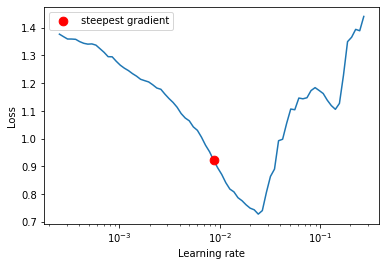

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 11.5 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
295 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
46.039    Total estimated model params size (MB)


0.008697490026177835
EPOCH NUMERO: 15


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

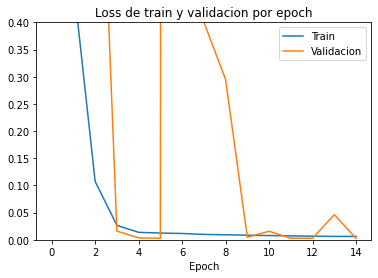

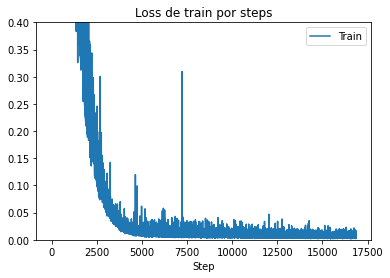

  0%|          | 0/276 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.002687833
El valor RMSE es igual a 0.0518443153980264
[0.0518443153980264]
Num Epochs mejor prueba: 15
RMSE mejor prueba: 0.0518443153980264

Error total por articulacion: [0.02297371 0.04503045 0.04546267 0.08161285 0.01744874 0.07952792
 0.03004363]
Articulacion 0 [-0.34 - 0.39] 0.73 3.15%
Articulacion 1 [-0.69 - 1.1] 1.79 2.52%
Articulacion 2 [-0.38 - 0.47] 0.85 5.35%
Articulacion 3 [-3.05 - -0.74] 2.31 3.53%
Articulacion 4 [-0.28 - 0.22] 0.5 3.49%
Articulacion 5 [1.22 - 3.03] 1.81 4.39%
Articulacion 6 [0.06 - 1.64] 1.58 1.9%


Los valores RMSE por demostracion son igual a [0.03623624444562356, 0.07466776757259344, 0.047526611309469786, 0.06633955046083467, 0.033289591665634645]
El valor medio de RMSE es 0.04541896002313054
El valor maximo de RMSE es 0.2683758504327271 y equivale a la prueba 183
El valor minimo de RMSE es 0.030428381267162193 y equivale a la prueba 191

Mejores RMSE: [0.030428381267162193, 0.030796987320166773, 

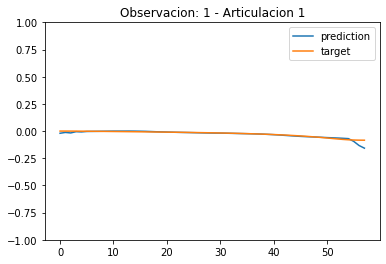

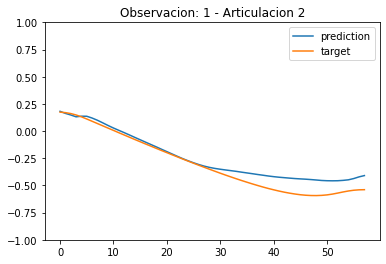

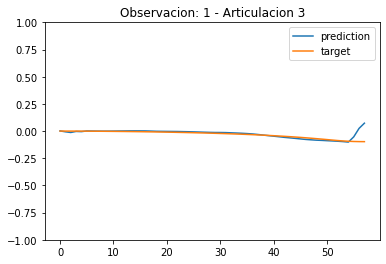

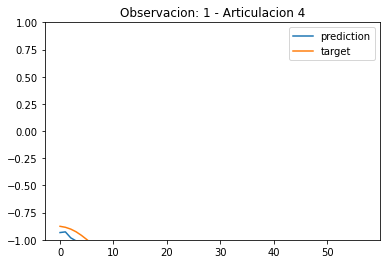

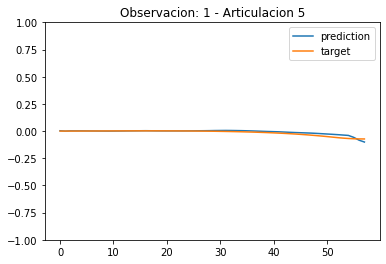

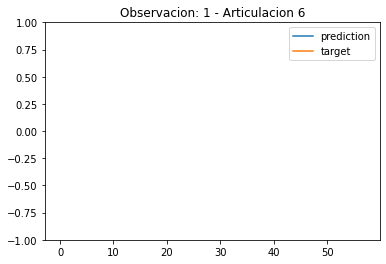

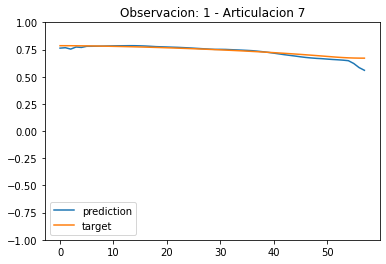

RMSE: 0.2683758504327271


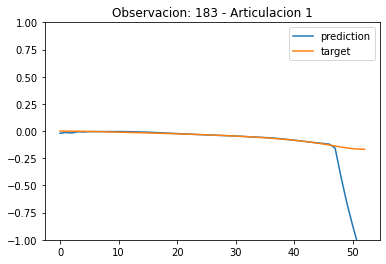

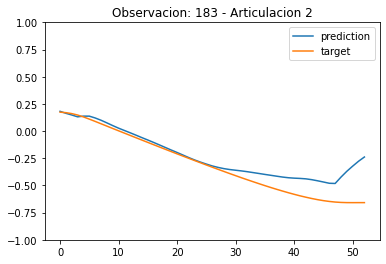

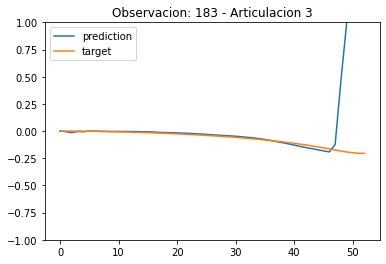

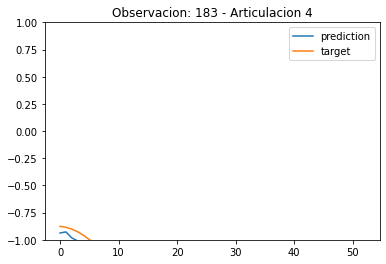

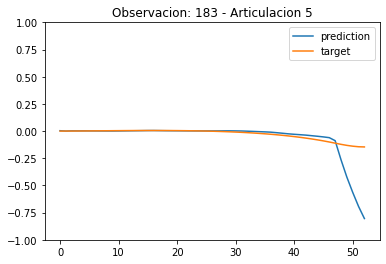

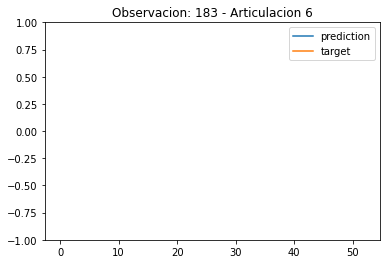

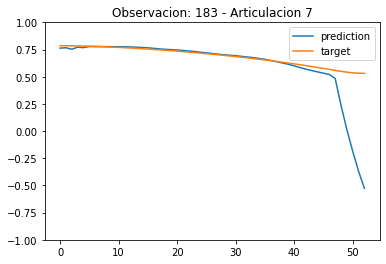

RMSE: 0.030428381267162193


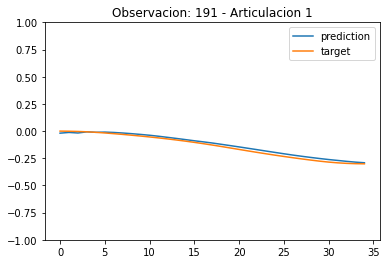

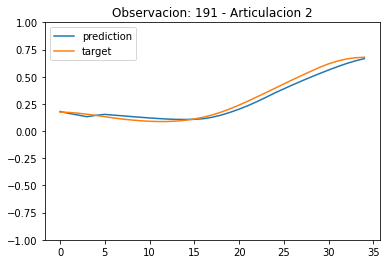

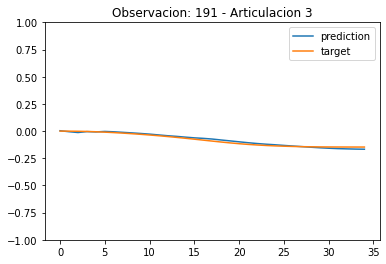

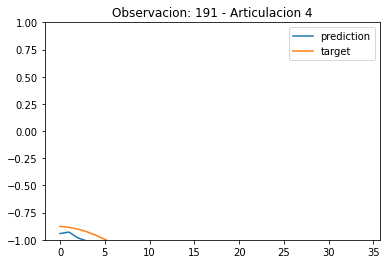

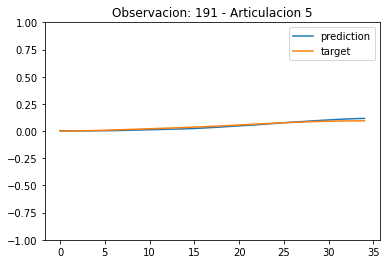

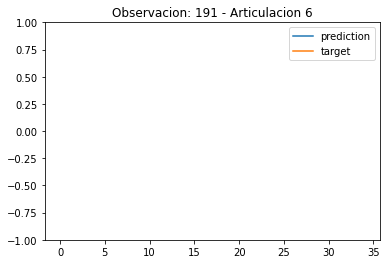

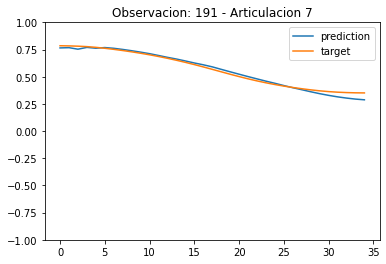

DATOS DEL MODELO:
 - Numero de Epoch: 15
 - RMSE: 0.0518443153980264


MultiImage(
  (fe): Sequential(
    (0): Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [17]:
# Clases para mas de una imagen

class ObsActionGetter(object):
    """
    Generic class that return the image and the action given an index
    """
    def __init__(self, carpeta_imagenes, archivo_acciones, tam_pruebas):
        # TODO: get a list of all image files
        self.archivo_acciones = archivo_acciones
        self.carpeta_imagenes = carpeta_imagenes
        self.tam_pruebas = tam_pruebas
        path, dirs, files = next(os.walk(self.carpeta_imagenes))
        self.image_files = list(range(len(files)))
        # TODO: get all made actions
        self.actions = []
        
    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.carpeta_imagenes + "Overhead_rgb/"), '*.png'))
        
    def __getitem__(self, idx):
        path_1 = self.carpeta_imagenes + "Front_rgb/" + str(idx) + ".png"
        path_2 = self.carpeta_imagenes + "Left_rgb/" + str(idx) + ".png"
        path_3 = self.carpeta_imagenes + "Right_rgb/" + str(idx) + ".png"
        #path_4 = self.carpeta_imagenes + "Right_rgb/" + str(idx) + ".png"
        #path_5 = self.carpeta_imagenes + "Wrist_rgb/" + str(idx) + ".png"
        
        im1 = np.array(Image.open(path_1))
        im2 = np.array(Image.open(path_2))
        im3 = np.array(Image.open(path_3))
        #im4 = np.array(Image.open(path_4))
        #im5 = np.array(Image.open(path_5))
        
        if (idx in self.tam_pruebas):
            im6 = np.array(Image.open(path_1))
            im7 = np.array(Image.open(path_2))
            im8 = np.array(Image.open(path_3))
            #im9 = np.array(Image.open(path_4))
            #im10 = np.array(Image.open(path_5))
            
        else :
            path_6 = self.carpeta_imagenes + "Front_rgb/" + str(idx-1) + ".png"
            path_7 = self.carpeta_imagenes + "Left_rgb/" + str(idx-1) + ".png"
            path_8 = self.carpeta_imagenes + "Right_rgb/" + str(idx-1) + ".png"
            #path_9 = self.carpeta_imagenes + "Right_rgb/" + str(idx-1) + ".png"
            #path_10 = self.carpeta_imagenes + "Wrist_rgb/" + str(idx-1) + ".png"
            
            im6 = np.array(Image.open(path_6))
            im7 = np.array(Image.open(path_7))
            im8 = np.array(Image.open(path_8))
            #im9 = np.array(Image.open(path_9))
            #im10 = np.array(Image.open(path_10))
            
        
        # TODO: get the action
        data = pd.read_csv(self.archivo_acciones, header = 0)
        action = np.float32(np.array(data.iloc[idx]))
        
        if (idx in self.tam_pruebas):
            action_prev_1 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_2 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-1) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-2) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-3) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.array([0,0,0,0,0,0,0], dtype="float32")
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        elif ((idx-4) in self.tam_pruebas):
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.array([0,0,0,0,0,0,0], dtype="float32")
            
        else:
            action_prev_1 = np.float32(np.array(data.iloc[idx-1]))
            action_prev_2 = np.float32(np.array(data.iloc[idx-2]))
            action_prev_3 = np.float32(np.array(data.iloc[idx-3]))
            action_prev_4 = np.float32(np.array(data.iloc[idx-4]))
            action_prev_5 = np.float32(np.array(data.iloc[idx-5]))
        
        '''
        im_actual = np.concatenate((im1, im2, im3, im4, im5), axis=2)
        im_previa = np.concatenate((im6, im7, im8, im9, im10), axis=2)
        imagen = np.concatenate((im_actual, im_previa), axis=2) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        '''
        # Return both image and action
        return im1, im2, im3, im6, im7, im8, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5

class ObsActionDataset(Dataset):
    """
    PyTorch Dataset for getting the data. In this case, from ObsActionGetter object
    """
    def __init__(self, obs_action_getter: ObsActionGetter, transformations: List[Callable]):
        super(ObsActionDataset, self).__init__()
        self.obs_action_getter = obs_action_getter
        self.transformations = transformations
        
    def __len__(self):
        return len(self.obs_action_getter)
    
    def __getitem__(self, idx):
        im1, im2, im3, im6, im7, im8, action, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5 = self.obs_action_getter[idx]
        for t in self.transformations:
            im1 = t(im1)
            im2 = t(im2)
            im3 = t(im3)
            #im4 = t(im4)
            #im5 = t(im5)
            im6 = t(im6)
            im7 = t(im7)
            im8 = t(im8)
            #im9 = t(im9)
            #im10 = t(im10)

        # Return both image and action
        im_t = torch.cat((im1, im2, im3), dim=0)
        im_prev_1 = torch.cat((im6, im7, im8), dim=0)
        imagen = torch.cat((im_t, im_prev_1), dim=0) # Canales = 2, Anchura = 1 -> 1,1,1...1,2
        
        # Return both image and action
        return (imagen, action_prev_1, action_prev_2, action_prev_3, action_prev_4, action_prev_5), action
    
class MultiImage(nn.Module):
    def __init__(self, fe, clf):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x1, x2, x3, x4, x5, x6 = x

        f1 = self.flatten(self.avg_pool(self.fe(x1)))
        f = torch.cat((f1, x2, x3, x4, x5, x6), dim=1)
        return self.clf(f)

# Para mas de una imagen

# Create train Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

train_obs_action_getter = ObsActionGetter('Train_dataset/', 'Train_dataset/Train_Actions_P.csv', tamPruebasTrain)
train_dataset = ObsActionDataset(train_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean),
                                                         (std))
                                ])

# Create test Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

test_obs_action_getter = ObsActionGetter('Test_dataset/', 'Test_dataset/Test_Actions_P.csv', tamPruebasTest)
test_dataset = ObsActionDataset(test_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean),
                                                         (std))
                                ])

# Create loaders (class that groups examples in batches)
# Uriz: train DataLoader should have shuffle to True
# Uriz: test DataLoader should have drop_last to False
# Uriz: use more workers to improve the training speed (load data in sever CPU threads). Otherwise we have a CPU -> GPU bottleneck
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=16)

print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))

RMSE_List = []
Model_List = []
Prediction_List = []
Label_List = []
LR_List = []
Loss_List = []

Epoch_List = [15]
num = len(os.listdir("../../tb_logs/my_model2"))
for eps in Epoch_List:
    
    # 1 - Se genera la red
    
    # To pretrain
    model = models.resnet18(pretrained=False)

    # Change the first convolution
    new_conv = torch.nn.Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = list(model.children())[1:]
    model = [new_conv] + model
    model = torch.nn.Sequential(*model)

    # Get only the feature extractor (remove avgpool and fc layers)
    fe = nn.Sequential(*list(model.children())[:-2])

    fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

    # Create custom head
    head_clf = nn.Sequential(
    nn.BatchNorm1d(512+7*5),
    nn.Dropout(0.25),
    nn.Linear(512+7*5, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
    )

    # Rebuild the model
    model = MultiImage(fe, head_clf)
    
    # 2 - Se busca el mejor Learning Rate a aplicar como maximo posible
    
    # Loss function
    criterion = nn.MSELoss()

    # We catch the optimizer of our lit_model
    # optimizer, lr_scheduler = pl_model.configure_optimizers()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Learning State Finder
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

    # Create trainer class
    try:
        BEST_LR = lr_finder.plot()[1]
    except:
        BEST_LR = 5.0E-03
    print(BEST_LR)
    
    if BEST_LR > 0.09:
        BEST_LR = 5.0E-03

    # 3 - Se prepara el Trainer y se entrena con el modelo LitModel
    
    # Number of iterations for LR Schedule
    ITERATIONS_PER_EPOCH = len(train_loader)
    
    logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model2")

    # Create PytorchLighting model for training
    pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * eps, lr=BEST_LR)

    NUM_GPUS = 1 if torch.cuda.is_available() else 0
    
    # Create trainer class
    trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                         log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)

    print("EPOCH NUMERO: " + str(eps))
    
    # Train the model
    trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)
    
    erroresTrainEpoch=[]
    erroresValEpoch=[]
    erroresTrainStep=[]
    erroresValStep=[]
    
    PATH_TB = os.listdir("../../tb_logs/my_model2/version_" + str(num))[1]
    PATH = "/home/hodei.zia/ImitAI Project/tb_logs/my_model2/version_" + str(num) + "/"
    path_to_events_file = PATH + PATH_TB
    num = num + 1
    
    # Plot de LOSS 
    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            if v.tag == 'training_loss_epoch':
                erroresTrainEpoch.append(v.simple_value)
            if v.tag == 'valid_loss_epoch':
                erroresValEpoch.append(v.simple_value)

            if v.tag == 'training_loss_step':
                erroresTrainStep.append(v.simple_value)
            #if v.tag == 'valid_loss_step':
            #    erroresValStep.append(v.simple_value)

    plt.plot(erroresTrainEpoch, label='Train')
    plt.plot(erroresValEpoch, label='Validacion')
    plt.title("Loss de train y validacion por epoch")
    plt.xlabel("Epoch")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()

    plt.plot(erroresTrainStep, label='Train')
    #plt.plot(erroresValStep, label='Validacion')
    plt.title("Loss de train por steps")
    plt.xlabel("Step")
    plt.ylim(0,0.4)
    plt.legend()
    plt.show()
    
    # 4 - Se predice el resultado
    
    # Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
    model = model.eval()
    # Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # To concatenate predictions and labels
    predictions = None
    labels = None
    # Surround all for not computing gradients
    with torch.no_grad():
        # Iterate over test dataset
        for x, y in tqdm.notebook.tqdm(test_loader):
            # Move to device
            x1, x2, x3, x4, x5, x6 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            x6 = x6.to(device)
            
            # Predict
            o = model((x1, x2, x3, x4, x5, x6))
            # Concatenate
            if predictions is None:
                predictions = o
            else:
                predictions = torch.cat((predictions, o), axis=0)

            if labels is None:
                labels = y
            else:
                labels = torch.cat((labels, y), axis=0)

        # Move predictions to CPU and to numpy
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

    mse = sklearn.metrics.mean_squared_error(labels, predictions)
    rmse = sqrt(mse)
    
    print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
    print("El valor RMSE es igual a " + str(rmse))

    # 5 - Se guardan los resultados 
    
    RMSE_List.append(rmse)
    Model_List.append(model)
    Prediction_List.append(predictions)
    Label_List.append(labels)
    LR_List.append(BEST_LR)
    #Loss_List.append(lr_finder.history['loss'][lr_finder.history['lr'].index(BEST_LR)])
    
    print(RMSE_List)

print("Num Epochs mejor prueba: "+str(Epoch_List[RMSE_List.index(min(RMSE_List))]))
print("RMSE mejor prueba: "+str(RMSE_List[RMSE_List.index(min(RMSE_List))]))
print("")

labels = Label_List[(RMSE_List.index(min(RMSE_List)))]
predictions = Prediction_List[(RMSE_List.index(min(RMSE_List)))]

# Error promedio de cada una de las articulaciones
joint_error = np.zeros(7)
minimo = np.zeros(7)
maximo = np.zeros(7)
for i in range(7):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print("Error total por articulacion: "+str(joint_error))

for i in range(7):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")
    
'''    
for i in range(7):
    plt.plot(predictions[0:50, i], label='prediction')
    plt.plot(labels[0:50, i], label='target')
    plt.xlabel('Pruebas')
    plt.ylabel('Valor Accion')
    plt.title('Articulacion ' + str(i+1))
    plt.legend(['Prediction','Target'])
    plt.show()
'''    
print("")
try:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '*.csv')

    ordenado=[]
    for i in observaciones:
        if i.split(".")[0].split("_")[1]!="Actions":
            ordenado.append(int(i.split(".")[0].split("_")[1]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
except:
    #print(os.getcwd())
    observaciones=fnmatch.filter(os.listdir('Test_dataset'), '0_V*')

    ordenado=[]
    for i in observaciones:
        ordenado.append(int(i.split(".")[0].split("_")[2]))
    ordenado=sorted(ordenado)

    tamPruebas=[0]
    j=0
    for observacion in ordenado:
        observacion="0_V_"+str(observacion)+".csv"
        tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
        j+=tam
        tamPruebas.append(j)

    #print(tamPruebas)
print("")

#MSE por demostracion
mseDem=[]
rmseDem=[]
for j in range(len(tamPruebas)-1):
    mseDem.append(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]]))
    rmseDem.append(sqrt(mseDem[j]))
''' 
print("Los valores del error cudratico medios (MSE) por demostracion son igual a "+str(mseDem[0:5]))
print("El valor medio de MSE es "+str(np.mean(mseDem)))
print("El valor maximo de MSE es "+str(max(mseDem))+" y equivale a la prueba "+str(np.argmax(mseDem)))
print("El valor minimo de MSE es "+str(min(mseDem))+" y equivale a la prueba "+str(np.argmin(mseDem)))
mMSE=sorted(mseDem)[0:5]
print("Mejores MSE: "+str(mMSE))
print("Mejores pruebas: "+str(mseDem.index(mMSE[0]))+", "+str(mseDem.index(mMSE[1]))+", "+str(mseDem.index(mMSE[2]))+", "+str(mseDem.index(mMSE[3]))+", "+str(mseDem.index(mMSE[4])))
pMSE=sorted(mseDem,reverse=True)[0:5]
print("Peores MSE: "+str(pMSE))
print("Peores pruebas: "+str(mseDem.index(pMSE[0]))+", "+str(mseDem.index(pMSE[1]))+", "+str(mseDem.index(pMSE[2]))+", "+str(mseDem.index(pMSE[3]))+", "+str(mseDem.index(pMSE[4])))

print("")
'''
print("Los valores RMSE por demostracion son igual a "+str(rmseDem[0:5]))
print("El valor medio de RMSE es "+str(np.mean(rmseDem)))
print("El valor maximo de RMSE es "+str(max(rmseDem))+" y equivale a la prueba "+str(np.argmax(rmseDem)))
print("El valor minimo de RMSE es "+str(min(rmseDem))+" y equivale a la prueba "+str(np.argmin(rmseDem)))
print("")
mRMSE=sorted(rmseDem)[0:5]
print("Mejores RMSE: "+str(mRMSE))
print("Mejores pruebas: "+str(rmseDem.index(mRMSE[0]))+", "+str(rmseDem.index(mRMSE[1]))+", "+str(rmseDem.index(mRMSE[2]))+", "+str(rmseDem.index(mRMSE[3]))+", "+str(rmseDem.index(mRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(mRMSE[0])])+", "+str(tamPruebas[rmseDem.index(mRMSE[1])])+", "+str(tamPruebas[rmseDem.index(mRMSE[2])])+", "+str(tamPruebas[rmseDem.index(mRMSE[3])])+", "+str(tamPruebas[rmseDem.index(mRMSE[4])]))
print("")
pRMSE=sorted(rmseDem,reverse=True)[0:5]
print("Peores RMSE: "+str(pRMSE))
print("Peores pruebas: "+str(rmseDem.index(pRMSE[0]))+", "+str(rmseDem.index(pRMSE[1]))+", "+str(rmseDem.index(pRMSE[2]))+", "+str(rmseDem.index(pRMSE[3]))+", "+str(rmseDem.index(pRMSE[4])))
print("Comienzan en la imagen: "+str(tamPruebas[rmseDem.index(pRMSE[0])])+", "+str(tamPruebas[rmseDem.index(pRMSE[1])])+", "+str(tamPruebas[rmseDem.index(pRMSE[2])])+", "+str(tamPruebas[rmseDem.index(pRMSE[3])])+", "+str(tamPruebas[rmseDem.index(pRMSE[4])]))
print("")

#Ploteamos la primera prueba
j=1
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la peor prueba
j=np.argmax(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    
#Ploteamos la mejor prueba
j=np.argmin(rmseDem)
print("RMSE:",sqrt(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]])))
for i in range(7):
    plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
    plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
    plt.title("Observacion: " + str(j) +" - Articulacion " + str(i+1))
    plt.ylim(-1,1)
    plt.legend()
    plt.show()

print("DATOS DEL MODELO:")
print(" - Numero de Epoch: " + str(Epoch_List[(RMSE_List.index(min(RMSE_List)))]))
print(" - RMSE: " + str(min(RMSE_List)))
name = 'RLBench_' + str(round(min(RMSE_List),3)) + '-5_P_Front+Left+Right'
torch.save(Model_List[(RMSE_List.index(min(RMSE_List)))], name)
model = torch.load(name)
model.eval()